In [1]:
%matplotlib notebook
import numpy as np

import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import WhiteKernel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import *
from numpy.fft import *
from csv import writer
import time

from scipy.stats import qmc

from numpy import arange
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e 
from numpy import pi
from numpy import meshgrid
from numpy import absolute


"""
PLOTTING FUNCTIONS
"""
def draw_plot(title, x, y, results):
    """
    Draw a 3D surface plot with the jet color scheme.
    Arguments:
        - title: plot title
        - x: x variable meshgrid in 2D
        - y: y variable meshgrid in 2D
        - results: z variable meshgrid in 2D
    """
    figure = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, results, cmap='jet')
    ax.set_title(title)
    ax.view_init(21,40)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
def scatter_plot_2d(X, Y):
    """
    Draw a 2D scatter plot.
    Arguments:
        - X: 1-D array or list of x coordinates
        - Y: 1-D array or list of y coordinates
    """
    figure = plt.figure()
    ax = plt.axes()
    ax.scatter(X,Y)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()

def scatter_plot_3d(X, Y, z):
    """
    Draw a 3D scatter plot.
    Arguments:
        - X: 1-D array or list of x coordinates
        - Y: 1-D array or list of y coordinates
        - z: 1-D array or list of z coordinates
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X,Y,z)
    plt.show()
    ax.view_init(21,40)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()    

def surf_plot_3d(x,y,z):
    """
    Draw a 3D surf plot.
    Arguments:
        - x: 1-D array or list of x coordinates
        - y: 1-D array or list of y coordinates
        - z: 1-D array or list of z coordinates
    """
    fig = plt.figure(figsize =(10, 6))
    ax = plt.axes(projection ='3d')
    ax.view_init(21,40)
    # Creating plot
    surf = ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0)
    fig.colorbar(surf) 
    # show plot
    plt.show()


"""
SAMPLING FUNCTIONS
"""
def lhs_sampler(dimension, numbers, scaler):
    """
    Latin-hypercube samples generator.
    Arguments:
        - dimension: number of dimensions
        - numbers: how many points to generate
        - scaler: float or integer representing max. and min. range of the function, e.g. 5 -> (-5,5)
    """
    sampler = qmc.LatinHypercube(d=dimension) #d = dimensions
    sampler = 2*scaler*sampler.random(n=numbers)-scaler #n = number of points
    return sampler[:,0], sampler[:,1]

def vertex_sampler(dimension, r_min, r_max):
    x_vertex = np.array([[r_min,r_min], [r_min,r_max], [r_max,r_min], [r_max,r_max], [(r_max+r_min)/2,(r_max+r_min)/2]])
    return x_vertex[:,0], x_vertex[:,1]

def vertex_sampler_3d(r_min_x, r_max_x, r_min_y, r_max_y, r_min_z, r_max_z):
    x_vertex = np.array([[r_min_x, r_min_y, r_min_z], 
                         [r_max_x, r_min_y, r_min_z], 
                         [r_min_x, r_min_y, r_max_z], 
                         [r_max_x, r_min_y, r_max_z],
                         [r_min_x, r_max_y, r_min_z], 
                         [r_max_x, r_max_y, r_min_z], 
                         [r_min_x, r_max_y, r_max_z], 
                         [r_max_x, r_max_y, r_max_z], 
                         [(r_max_x+r_min_x)/2,(r_max_y+r_min_y)/2, (r_max_z+r_min_z)/2]])
    return x_vertex[:,0], x_vertex[:,1], x_vertex[:,2]

"""
SURROGATE MODELING FUNCTIONS
"""
def gpr_train(x_train, y_train):
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-6, 1e1)) + 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-4, 10.0), nu=1.5)
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=300)
    gaussian_process.fit(x_train, y_train)
    gaussian_process.kernel_
    return gaussian_process

def predict(regressor, x, y, std):
    pos = np.vstack(map(np.ravel, [x,y])).T
    return regressor.predict(pos, return_std=std), pos[:,0], pos[:,1]


"""
EVALUATION FUNCTIONS
"""
def squared_error(x_coord, y_coord, actual_value, mean_prediction):
    return np.column_stack((x_coord, y_coord,(actual_value-mean_prediction)**2))

def error(x_coord, y_coord, actual_value, mean_prediction):
    return np.column_stack((x_coord, y_coord,(actual_value-mean_prediction)))

def relative_error(x_coord, y_coord, actual_value, mean_prediction):
    return np.column_stack((x_coord, y_coord,(mean_prediction-actual_value)/actual_value*100))

def mae(x_coord, y_coord, actual_value, mean_prediction):
    return absolute(error(x_coord, y_coord, actual_value, mean_prediction)[:,2]).mean()

def mse(x_coord, y_coord, actual_value, mean_prediction):
    return absolute(squared_error(x_coord, y_coord, actual_value, mean_prediction)[:,2]).mean()

def mean():
    # Not implemented yet.
    return 1


"""
2D TEST FUNCTIONS
"""
def bohachevsky(x,y):  
    return x**2 +2*(y**2)-0.3*cos(3*pi*x)-0.4*cos(4*pi*y)+0.7

def ackley(x, y):
	return -20.0 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2))) - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y))) + e + 20

def himmelblau(x, y):
	return (x**2 + y - 11)**2 + (x + y**2 -7)**2

def peaks(x, y):
	return 3*(1-x**2)*e**(-x**2-(y+1)**2)-10*((x/5)-x**3-y**5)*e**(-x**2-y**2)-(1/3)*e**(-(x+1)**2-y**2)


"""
ACTIVE-LEARNING FUNCTIONS
"""
def variance_based_sampling(X, Y, xaxis, yaxis, niters, function):
    X_new = X
    Y_new = Y
    mse_list = []
    
    for iters in range(0, niters):
        if function == "peaks":
            z = peaks(X_new, Y_new)
        elif function == "bohachevsky":
            z = bohachevsky(X_new, Y_new)
        elif function == "ackley":
            z = ackley(X_new, Y_new)
        elif function == "himmelblau":
            z = himmelblau(X_new, Y_new)
        else:
            print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
            break;
        x_train = np.column_stack((X_new,Y_new))
        y_train = z
        print("Len x_train: "+str(len(x_train))) 
        print("Len y_train: "+str(len(y_train))) 

        # K-Folding
        cumulative_sum = np.zeros(len(xaxis)*len(yaxis))
        for j in range(0,len(x_train)):
            globals()[f'X_train_{j}'] = np.delete(x_train, j, axis=0)
            globals()[f'Y_train_{j}'] = np.delete(y_train, j, axis=0)
            globals()[f'gaussian_process_{j}'] = gpr_train(globals()[f'X_train_{j}'], globals()[f'Y_train_{j}'])
            globals()[f'mean_prediction_{j}'], globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'] = predict(globals()[f'gaussian_process_{j}'], x, y, False)
            cumulative_sum += globals()[f'mean_prediction_{j}']
            #print(cumulative_sum[:10])
        mean_prediction_kfolding = cumulative_sum/len(x_train) 
        
        if iters == 0:
            if function == "peaks":
                actual_value = peaks(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
            elif function == "bohachevsky":
                actual_value = bohachevsky(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
            elif function == "ackley":
                actual_value = ackley(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
            elif function == "himmelblau":
                actual_value = himmelblau(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
            else:
                print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
                break;

        iter_mse = mse(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], actual_value, mean_prediction_kfolding)

        cumulative_variance = np.zeros(len(xaxis)*len(yaxis))
        for j in range(0,len(x_train)):
            cumulative_variance += (globals()[f'mean_prediction_{j}']-mean_prediction_kfolding)**2
        variance = cumulative_variance/len(x_train)

        variances_array = np.column_stack((globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], np.sqrt(variance)))
        max_variance_x, max_variance_y, max_variance = variances_array[variances_array[:,2].argmax(),:]

        print("Max variances: "+str(max_variance))
        print("Max variance x: "+str(max_variance_x))
        print("Max variance y: "+str(max_variance_y))
        print("MSE: "+str(iter_mse))
        print("Iter "+str(iters+1)+" of "+str(niters))

        X_new = np.append(X_new, max_variance_x)
        Y_new = np.append(Y_new, max_variance_y)
        mse_list.append(iter_mse)
        iters+=1
        
    return X_new, Y_new, mse_list

def maximum_distance_sampling(x,y,X_new,Y_new):
    pos = np.vstack(map(np.ravel, [x,y])).T
    points = np.column_stack((X_new,Y_new))
    array_distances = []
    for j in range(len(pos)):
        min_distance = np.Inf;
        min_dist_point = []
        for i in range(len(points)):
            dist = np.linalg.norm(pos[j]-points[i])
            #print(pos[j], points[i], dist)
            if dist < min_distance:
                min_distance = dist
                min_dist_point = points[i]
        #print("Min dist. point: ", pos[j], min_dist_point, min_distance)
        array_distances.append([pos[j], min_dist_point, min_distance])
    column_names = ["point", "reference", "distance"]
    distances_df = pd.DataFrame(array_distances, columns = column_names)
    distances_df['distance'] = distances_df['distance'].div(float(distances_df['distance'].max()))
    return distances_df.loc[distances_df['distance'].idxmax()].point

def maximum_distance_list(x,y,X_new,Y_new):
    pos = np.vstack(map(np.ravel, [x,y])).T
    points = np.column_stack((X_new,Y_new))
    array_distances = []
    for j in range(len(pos)):
        min_distance = np.Inf;
        min_dist_point = []
        for i in range(len(points)):
            dist = np.linalg.norm(pos[j]-points[i])
            #print(pos[j], points[i], dist)
            if dist < min_distance:
                min_distance = dist
                min_dist_point = points[i]
        #print("Min dist. point: ", pos[j], min_dist_point, min_distance)
        array_distances.append([pos[j], min_dist_point, min_distance])
    column_names = ["point", "reference", "distance"]
    distances_df = pd.DataFrame(array_distances, columns = column_names)
    distances_df['distance'] = distances_df['distance'].div(float(distances_df['distance'].max()))
    return distances_df['point'].str[0].to_numpy(), distances_df['point'].str[1].to_numpy(), distances_df['distance'].to_numpy()
    
def maximum_distance_list_3d(pos_ordered,x_train):
    array_distances = []
    for j in range(len(pos_ordered)):
        min_distance = np.Inf;
        min_dist_point = []
        for i in range(len(x_train)):
            dist = np.linalg.norm(pos_ordered[j]-x_train[i])
            #print(pos[j], points[i], dist)
            if dist < min_distance:
                min_distance = dist
                min_dist_point = x_train[i]
        #print("Min dist. point: ", pos[j], min_dist_point, min_distance)
        array_distances.append([pos_ordered[j], min_dist_point, min_distance])
    column_names = ["point", "reference", "distance"]
    distances_df = pd.DataFrame(array_distances, columns = column_names)
    distances_df['distance'] = distances_df['distance'].div(float(distances_df['distance'].max()))
    return distances_df['point'].str[0].to_numpy(), distances_df['point'].str[1].to_numpy(), distances_df['point'].str[2].to_numpy(), distances_df['distance'].to_numpy()
    
"""
ONE-SHOT FUNCTIONS (based on Scikit-Optimize)
"""

np.random.seed(123)
#n_samples = 10
#space = Space([(-5., 10.), (0., 15.)]) -> (x_min, x_max), (y_min, y_max)

def random_sampler(n_samples, r_min, r_max):
    from skopt.space import Space
    space = Space([(r_min, r_max), (r_min, r_max)])
    x = space.rvs(n_samples)
    x_numpy = np.array(x)
    print("Generated "+str(n_samples)+" with Random")
    return x_numpy[:,0], x_numpy[:,1]

def sobol_sampler(n_samples, r_min, r_max):
    from skopt.space import Space
    from skopt.sampler import Sobol
    space = Space([(r_min, r_max), (r_min, r_max)])
    sobol = Sobol()
    x = sobol.generate(space.dimensions, n_samples)
    x_numpy = np.array(x)
    print("Generated "+str(n_samples)+" with Sobol")
    return x_numpy[:,0], x_numpy[:,1]

def latin_sampler(n_samples, r_min, r_max, latin_type):
    from skopt.space import Space
    from skopt.sampler import Lhs
    space = Space([(r_min, r_max), (r_min, r_max)])
    lhs = Lhs(lhs_type=latin_type, criterion=None)
    x = lhs.generate(space.dimensions, n_samples)
    x_numpy = np.array(x)
    print("Generated "+str(n_samples)+" with LHS type "+latin_type)
    return x_numpy[:,0], x_numpy[:,1]

def latin_sampler_optimizer(n_samples, r_min, r_max, optimizer):
    from skopt.space import Space
    from skopt.sampler import Lhs
    space = Space([(r_min, r_max), (r_min, r_max)])
    lhs = Lhs(criterion=optimizer, iterations=1000)
    x = lhs.generate(space.dimensions, n_samples)
    x_numpy = np.array(x)
    print("Generated "+str(n_samples)+" with LHS optimizer "+optimizer)
    return x_numpy[:,0], x_numpy[:,1]

def halton_sampler(n_samples, r_min, r_max):
    from skopt.space import Space
    from skopt.sampler import Halton
    space = Space([(r_min, r_max), (r_min, r_max)])
    halton = Halton()
    x = halton.generate(space.dimensions, n_samples)
    x_numpy = np.array(x)
    print("Generated "+str(n_samples)+" with Halton")
    return x_numpy[:,0], x_numpy[:,1]

# Caution, this one is pretty slow!!!
def hammersly_sampler(n_samples, r_min, r_max):
    from skopt.space import Space
    from skopt.sampler import Hammersly
    space = Space([(r_min, r_max), (r_min, r_max)])
    hammersly = Hammersly()
    x = hammersly.generate(space.dimensions, n_samples)
    x_numpy = np.array(x)
    print("Generated "+str(n_samples)+" with Hammersly")
    return x_numpy[:,0], x_numpy[:,1]


---


# Automatic Variance-based active-learning

In [14]:
r_min, r_max = -3.0, 3.0
xaxis = np.linspace(r_min, r_max, 100)
yaxis = np.linspace(r_min, r_max, 100)

x, y = meshgrid(xaxis, yaxis)
results = peaks(x, y)

#draw_plot('Peaks Function', x, y, results)

X, Y = lhs_sampler(2, 10, r_max)
z = peaks(X, Y)
x_train = np.column_stack((X,Y))
y_train = z
#scatter_plot_3d(X,Y,z)

X_new = X
Y_new = Y

for iters in range(0, 40):
    z = peaks(X_new, Y_new)
    x_train = np.column_stack((X_new,Y_new))
    y_train = z
    print("Len x_train: "+str(len(x_train))) 
    print("Len y_train: "+str(len(y_train))) 

    # K-Folding
    cumulative_sum = np.zeros(len(xaxis)*len(yaxis))
    for j in range(0,len(x_train)):
        globals()[f'X_train_{j}'] = np.delete(x_train, j, axis=0)
        globals()[f'Y_train_{j}'] = np.delete(y_train, j, axis=0)
        globals()[f'gaussian_process_{j}'] = gpr_train(globals()[f'X_train_{j}'], globals()[f'Y_train_{j}'])
        globals()[f'mean_prediction_{j}'], globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'] = predict(globals()[f'gaussian_process_{j}'], x, y, False)
        cumulative_sum += globals()[f'mean_prediction_{j}']
        #print(cumulative_sum[:10])
    mean_prediction_kfolding = cumulative_sum/len(x_train) 
    actual_value = peaks(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
    iter_mse = mse(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], actual_value, mean_prediction_kfolding)

    cumulative_variance = np.zeros(len(xaxis)*len(yaxis))
    for j in range(0,len(x_train)):
        cumulative_variance += (globals()[f'mean_prediction_{j}']-mean_prediction_kfolding)**2
    variance = cumulative_variance/len(x_train)

    variances_array = np.column_stack((globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], np.sqrt(variance)))
    max_variance_x, max_variance_y, max_variance = variances_array[variances_array[:,2].argmax(),:]

    print("Max variances: "+str(max_variance))
    print("Max variance x: "+str(max_variance_x))
    print("Max variance y: "+str(max_variance_y))
    print("MSE: "+str(iter_mse))
    
    X_new = np.append(X_new, max_variance_x)
    Y_new = np.append(Y_new, max_variance_y)
    
    iters+=1
    


Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

Max variances: 1.3637540380111888
Max variance x: 0.3333333333333335
Max variance y: -2.0303030303030303
MSE: 2.475750923586576
Len x_train: 11
Len y_train: 11


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such 

Max variances: 0.8433918769550309
Max variance x: 1.0
Max variance y: 0.09090909090909083
MSE: 2.486330197338827
Len x_train: 12
Len y_train: 12


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such 

Max variances: 0.5782263794884708
Max variance x: 0.030303030303030276
Max variance y: -2.696969696969697
MSE: 2.3032582976908698
Len x_train: 13
Len y_train: 13


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such 

Max variances: 0.6082521080231802
Max variance x: 0.6969696969696972
Max variance y: -1.4242424242424243
MSE: 2.3232192222697607
Len x_train: 14
Len y_train: 14


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such 

Max variances: 0.5392399949888509
Max variance x: -0.8787878787878789
Max variance y: 2.0303030303030303
MSE: 2.2133008857556122
Len x_train: 15
Len y_train: 15


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: Th

Max variances: 0.4816879019787624
Max variance x: -1.0
Max variance y: 1.3030303030303028
MSE: 2.050509885777004
Len x_train: 16
Len y_train: 16


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "seq

Max variances: 0.26820842910678305
Max variance x: -0.8181818181818183
Max variance y: 0.6969696969696972
MSE: 2.038999356712806
Len x_train: 17
Len y_train: 17


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such 

Max variances: 0.36092537035599365
Max variance x: -0.7575757575757573
Max variance y: 0.27272727272727293
MSE: 1.9880838972525503
Len x_train: 18
Len y_train: 18


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: Th

Max variances: 0.20473298074015228
Max variance x: -2.212121212121212
Max variance y: 1.0
MSE: 1.9208090576920906
Len x_train: 19
Len y_train: 19


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: Th

Max variances: 0.2866436118045333
Max variance x: -2.878787878787879
Max variance y: 0.9393939393939394
MSE: 1.8518577855106826
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "s

Max variances: 0.16665509212010982
Max variance x: -1.4848484848484849
Max variance y: 0.6363636363636367
MSE: 1.8182411563118825
Len x_train: 21
Len y_train: 21


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack mu

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.27385848234001775
Max variance x: -1.7272727272727273
Max variance y: 0.09090909090909083
MSE: 1.641788286948008
Len x_train: 22
Len y_train: 22


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such 

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.16225243210170764
Max variance x: 0.8181818181818183
Max variance y: 0.8787878787878789
MSE: 1.6230724298027022
Len x_train: 23
Len y_train: 23


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such 

Max variances: 0.2790527993112268
Max variance x: 0.6363636363636367
Max variance y: 1.4242424242424248
MSE: 1.32849457012369
Len x_train: 24
Len y_train: 24


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such 

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 1.0666853034566377
Max variance x: 0.5151515151515151
Max variance y: 1.9696969696969697
MSE: 0.8022065348477939
Len x_train: 25
Len y_train: 25


/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: Co

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such 

Max variances: 0.682312031038865
Max variance x: 0.5151515151515151
Max variance y: 2.575757575757576
MSE: 0.7465212726498396
Len x_train: 26
Len y_train: 26


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack m

Max variances: 0.29597135408812825
Max variance x: 0.8181818181818183
Max variance y: -0.6363636363636362
MSE: 0.7380398488064128
Len x_train: 27
Len y_train: 27


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "seq

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must

Max variances: 0.34959538355475506
Max variance x: 1.666666666666667
Max variance y: -0.33333333333333304
MSE: 0.7435207701933472
Len x_train: 28
Len y_train: 28


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

Max variances: 0.29309044692714087
Max variance x: 0.8787878787878789
Max variance y: 3.0
MSE: 0.7249945183346034
Len x_train: 29
Len y_train: 29


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

Max variances: 0.21303157775770784
Max variance x: 1.0606060606060606
Max variance y: 0.8181818181818183
MSE: 0.7281373841757554
Len x_train: 30
Len y_train: 30


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.42134783957146144
Max variance x: 0.3333333333333335
Max variance y: 0.6363636363636367
MSE: 0.780158916901365
Len x_train: 31
Len y_train: 31


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

Max variances: 0.25114517585691476
Max variance x: 1.7272727272727275
Max variance y: 0.7575757575757578
MSE: 0.8095802984296536
Len x_train: 32
Len y_train: 32


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

Max variances: 0.2034422184551949
Max variance x: 1.2424242424242422
Max variance y: 1.4848484848484853
MSE: 0.8153624443047799
Len x_train: 33
Len y_train: 33


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

Max variances: 0.32136495409305155
Max variance x: 1.3030303030303028
Max variance y: 1.8484848484848486
MSE: 0.6859024191709256
Len x_train: 34
Len y_train: 34


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

Max variances: 0.24247881063581553
Max variance x: 2.212121212121212
Max variance y: 0.6363636363636367
MSE: 0.680087297225303
Len x_train: 35
Len y_train: 35


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

Max variances: 0.23572998790232713
Max variance x: 2.333333333333334
Max variance y: 1.7272727272727275
MSE: 0.6765401670343929
Len x_train: 36
Len y_train: 36


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/dani/anaconda3/lib/python3

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

Max variances: 0.1875680119097194
Max variance x: 0.39393939393939403
Max variance y: 1.3636363636363633
MSE: 0.6694477117081781
Len x_train: 37
Len y_train: 37


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: Conve

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/dani/anaconda3/lib/python3

Max variances: 0.3424856077223792
Max variance x: -0.15151515151515138
Max variance y: 1.4848484848484853
MSE: 0.5673768894139191
Len x_train: 38
Len y_train: 38


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: Conve

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

Max variances: 0.21367811471782042
Max variance x: -0.7575757575757573
Max variance y: -0.33333333333333304
MSE: 0.5423196096221271
Len x_train: 39
Len y_train: 39


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: Conve

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_

Max variances: 0.27454574646828
Max variance x: -0.6969696969696968
Max variance y: -0.9393939393939394
MSE: 0.4409149062711811
Len x_train: 40
Len y_train: 40


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: Conve

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kern

Max variances: 0.1757679304781701
Max variance x: 3.0
Max variance y: 2.0303030303030303
MSE: 0.436562163846926
Len x_train: 41
Len y_train: 41


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: Conve

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kern

Max variances: 0.16939459051202305
Max variance x: 0.21212121212121238
Max variance y: -0.5757575757575757
MSE: 0.43538254781770963
Len x_train: 42
Len y_train: 42


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

Max variances: 0.21431846669128887
Max variance x: 0.030303030303030276
Max variance y: -0.5757575757575757
MSE: 0.34697829262996277
Len x_train: 43
Len y_train: 43


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: Conve

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

Max variances: 0.3565369807208761
Max variance x: -1.121212121212121
Max variance y: -1.303030303030303
MSE: 0.29150159983764995
Len x_train: 44
Len y_train: 44


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: Conve

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

Max variances: 0.2681552629213191
Max variance x: 1.9090909090909092
Max variance y: -1.4848484848484849
MSE: 0.2908783702194314
Len x_train: 45
Len y_train: 45


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kern

Max variances: 0.22395058582294047
Max variance x: -1.2424242424242424
Max variance y: -0.5151515151515151
MSE: 0.26596343615599555
Len x_train: 46
Len y_train: 46


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

Max variances: 0.2041175897875802
Max variance x: -1.8484848484848484
Max variance y: -0.9393939393939394
MSE: 0.2517032223395076
Len x_train: 47
Len y_train: 47


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

Max variances: 0.1666224668420753
Max variance x: 0.15151515151515138
Max variance y: 0.39393939393939403
MSE: 0.24112518324972163
Len x_train: 48
Len y_train: 48


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

Max variances: 0.20328429672587445
Max variance x: 2.2727272727272725
Max variance y: -1.9090909090909092
MSE: 0.2205441858451606
Len x_train: 49
Len y_train: 49


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

Max variances: 0.15059657097305493
Max variance x: -2.515151515151515
Max variance y: -0.39393939393939403
MSE: 0.22000126409304635


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


<IPython.core.display.Javascript object>


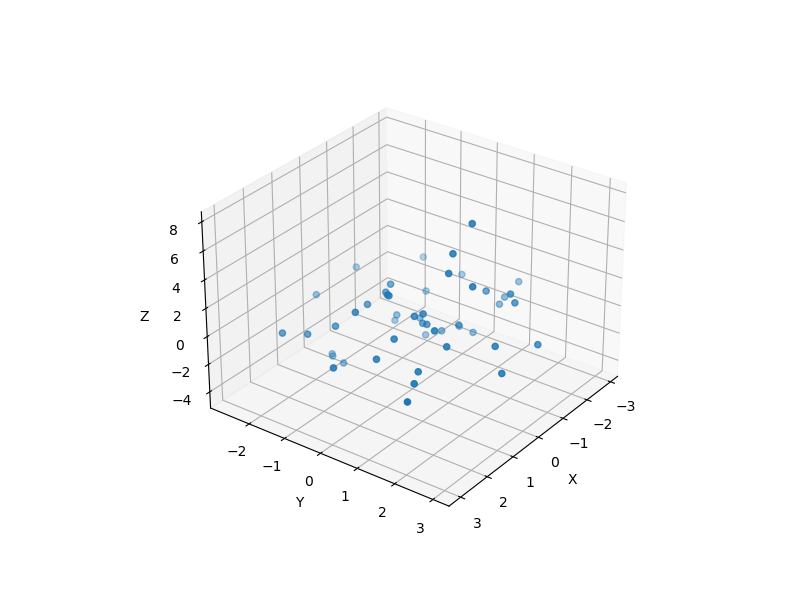

In [15]:
scatter_plot_3d(X_new, Y_new, peaks(X_new, Y_new))

# Automatic random sampling

In [49]:
import random
z = peaks(X, Y)
x_train = np.column_stack((X,Y))
y_train = z
#scatter_plot_3d(X,Y,z)

X_new_random = X
Y_new_random = Y

for iters in range(0, 40):
    z = peaks(X_new_random, Y_new_random)
    x_train = np.column_stack((X_new_random,Y_new_random))
    y_train = z
    print("Len x_train: "+str(len(x_train))) 
    print("Len y_train: "+str(len(y_train))) 

    # K-Folding
    cumulative_sum = np.zeros(len(xaxis)*len(yaxis))
    for j in range(0,len(x_train)):
        globals()[f'X_train_{j}'] = np.delete(x_train, j, axis=0)
        globals()[f'Y_train_{j}'] = np.delete(y_train, j, axis=0)
        globals()[f'gaussian_process_{j}'] = gpr_train(globals()[f'X_train_{j}'], globals()[f'Y_train_{j}'])
        globals()[f'mean_prediction_{j}'], globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'] = predict(globals()[f'gaussian_process_{j}'], x, y, False)
        cumulative_sum += globals()[f'mean_prediction_{j}']
        #print(cumulative_sum[:10])
    mean_prediction_kfolding = cumulative_sum/len(x_train) 
    actual_value = peaks(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
    iter_mse = mse(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], actual_value, mean_prediction_kfolding)

    print("MSE: "+str(iter_mse))
    
    next_index = random.randint(0, len(globals()[f'x_coord_{j}'])-1)
    X_new_random = np.append(X_new_random, globals()[f'x_coord_{j}'][next_index])
    Y_new_random = np.append(Y_new_random, globals()[f'y_coord_{j}'][next_index])
    
    iters+=1
    


Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 2.475762106179169
Len x_train: 11
Len y_train: 11


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.943874977813357
Len x_train: 12
Len y_train: 12


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


MSE: 1.7099383969101087
Len x_train: 13
Len y_train: 13


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.5978728642930107
Len x_train: 14
Len y_train: 14


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.51046188760947
Len x_train: 15
Len y_train: 15


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.3102211748896289
Len x_train: 16
Len y_train: 16


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.2709562265521124
Len x_train: 17
Len y_train: 17


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.2612480094278868
Len x_train: 18
Len y_train: 18


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.2465626103264815
Len x_train: 19
Len y_train: 19


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


MSE: 1.346674673522237
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.3370545823265194
Len x_train: 21
Len y_train: 21


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.329452598430143
Len x_train: 22
Len y_train: 22


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.2653831049399829
Len x_train: 23
Len y_train: 23


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.4228023336744378
Len x_train: 24
Len y_train: 24


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.3398809456675953
Len x_train: 25
Len y_train: 25


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.3288788166968033
Len x_train: 26
Len y_train: 26


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.433633281889032
Len x_train: 27
Len y_train: 27


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.4302410878694107
Len x_train: 28
Len y_train: 28


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


MSE: 1.417704736210476
Len x_train: 29
Len y_train: 29


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.1690465389443911
Len x_train: 30
Len y_train: 30


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.158429095245667
Len x_train: 31
Len y_train: 31


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.146204107247473
Len x_train: 32
Len y_train: 32


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.1471905155734468
Len x_train: 33
Len y_train: 33


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.1450686267756858
Len x_train: 34
Len y_train: 34


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 1.15279984693251
Len x_train: 35
Len y_train: 35


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kern

MSE: 1.0877692011046856
Len x_train: 36
Len y_train: 36


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

MSE: 0.9505784679038043
Len x_train: 37
Len y_train: 37


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kern

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kern

MSE: 0.5993079023806509
Len x_train: 38
Len y_train: 38


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


MSE: 0.5956884532788029
Len x_train: 39
Len y_train: 39


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kern

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 0.5572310159320537
Len x_train: 40
Len y_train: 40


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 0.5655401666000887
Len x_train: 41
Len y_train: 41


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 0.545370055136484
Len x_train: 42
Len y_train: 42


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 0.477808355992821
Len x_train: 43
Len y_train: 43


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kern

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kern

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 0.29663031479708274
Len x_train: 44
Len y_train: 44


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 0.21614876844437395
Len x_train: 45
Len y_train: 45


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 0.21817474049260485
Len x_train: 46
Len y_train: 46


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 0.21561721604225362
Len x_train: 47
Len y_train: 47


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

MSE: 0.20616082677312642
Len x_train: 48
Len y_train: 48


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


MSE: 0.20618771165006133
Len x_train: 49
Len y_train: 49


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kern

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/k

/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be

MSE: 0.19521104347395607


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/3666723436.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


-----



# HERE IS WHERE THE EXPERIMENTS BEGIN



-----

# Test with SciKit Optimize samplers for one-shot

In [320]:
array_results = []

column_names = ["number_of_points", "method", "function", "mse", "X_new", "Y_new"]

number_of_points = [5, 10, 20, 50, 100]
functions = ["bohachevsky", "ackley", "himmelblau", "peaks"]
methods = ["hammersly", "halton", "random", "sobol", "LHSclassic", "LHScentered", "LHSmaximin", "LHScorrelation", "LHSratio"]
for function in functions:
    for method in methods:
        for number in number_of_points:
            
            if function == "peaks":
                r_min, r_max = -3.0, 3.0
            elif function == "bohachevsky":
                r_min, r_max = -100.0, 100.0
            elif function == "ackley":
                r_min, r_max = -2.0, 2.0
            elif function == "himmelblau":
                r_min, r_max = -5.0, 5.0
            else:
                print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
                break;
            
            if method == "hammersly":
                X_new, Y_new = hammersly_sampler(number, r_min, r_max)
            elif method == "halton":
                X_new, Y_new = halton_sampler(number, r_min, r_max)
            elif method == "random":
                X_new, Y_new = random_sampler(number, r_min, r_max)
            elif method == "sobol":
                X_new, Y_new = sobol_sampler(number, r_min, r_max)
            elif method == "LHSclassic":
                X_new, Y_new = latin_sampler(number, r_min, r_max, "classic")
            elif method == "LHScentered":
                X_new, Y_new = latin_sampler(number, r_min, r_max, "centered")
            elif method == "LHSmaximin":
                X_new, Y_new = latin_sampler_optimizer(number, r_min, r_max, "maximin")
            elif method == "LHScorrelation":
                X_new, Y_new = latin_sampler_optimizer(number, r_min, r_max, "correlation")
            elif method == "LHSratio":
                X_new, Y_new = latin_sampler_optimizer(number, r_min, r_max, "ratio")
            else:
                print("No correct method specified. Available: hammersly, halton, random, sobol, LHSclassic, LHScentered, LHSmaximin, LHScorrelation, LHSratio")
                break;

            if function == "peaks":
                z = peaks(X_new, Y_new)
            elif function == "bohachevsky":
                z = bohachevsky(X_new, Y_new)
            elif function == "ackley":
                z = ackley(X_new, Y_new)
            elif function == "himmelblau":
                z = himmelblau(X_new, Y_new)
            else:
                print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
                break;
            
            print("Function: "+function+". r_min, r_max = "+str(r_min)+", "+str(r_max))
            xaxis = np.linspace(r_min, r_max, 100)
            yaxis = np.linspace(r_min, r_max, 100)

            x, y = meshgrid(xaxis, yaxis)
            x_train = np.column_stack((X_new,Y_new))
            y_train = z
            print("Len x_train: "+str(len(x_train))) 
            print("Len y_train: "+str(len(y_train)))
            
            # TRAINING and PREDICTION
            gaussian_process = gpr_train(x_train, y_train)
            mean_prediction, x_coord, y_coord = predict(gaussian_process, x, y, False)
            
            # EVALUATION
            actual_value = peaks(x_coord, y_coord)
            if function == "peaks":
                actual_value = peaks(x_coord, y_coord)
            elif function == "bohachevsky":
                actual_value = bohachevsky(x_coord, y_coord)
            elif function == "ackley":
                actual_value = ackley(x_coord, y_coord)
            elif function == "himmelblau":
                actual_value = himmelblau(x_coord, y_coord)
            else:
                print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
                break;
                
            #errores = error(x_coord, y_coord, actual_value, mean_prediction)
            errores_mse = mse(x_coord, y_coord, actual_value, mean_prediction)
            
            array_results.append([number, method, function, errores_mse, X_new, Y_new])
            
df_one_shot = pd.DataFrame(array_results, columns = column_names)
df_one_shot.to_csv('one_shot_run_10.csv')


Generated 5 with Hammersly
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 10 with Hammersly
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 20 with Hammersly
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 50 with Hammersly
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 100 with Hammersly
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 5 with Halton
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 10 with Halton
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 20 with Halton
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 50 with Halton
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 100 with Halton
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 5 with Random
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 10 with Random
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 20 with Random
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 50 with Random
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 100 with Random
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 5 with Sobol
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 10 with Sobol
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 20 with Sobol
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 50 with Sobol
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 100 with Sobol
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 5 with LHS type classic
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 10 with LHS type classic
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 20 with LHS type classic
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 50 with LHS type classic
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 100 with LHS type classic
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 5 with LHS type centered
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS type centered
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 20 with LHS type centered
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 50 with LHS type centered
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 100 with LHS type centered
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 5 with LHS optimizer maximin
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 10 with LHS optimizer maximin
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 20 with LHS optimizer maximin
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureW

Generated 50 with LHS optimizer maximin
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureW

Generated 100 with LHS optimizer maximin
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 5 with LHS optimizer correlation
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 10 with LHS optimizer correlation
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 20 with LHS optimizer correlation
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 50 with LHS optimizer correlation
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 100 with LHS optimizer correlation
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureW

Generated 5 with LHS optimizer ratio
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-pack

Generated 10 with LHS optimizer ratio
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packag

Generated 20 with LHS optimizer ratio
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 50 with LHS optimizer ratio
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWa

Generated 100 with LHS optimizer ratio
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureW

Generated 5 with Hammersly
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with Hammersly
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with Hammersly
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with Hammersly
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with Hammersly
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with Halton
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with Halton
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with Halton
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with Halton
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with Halton
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with Random
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with Random
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with Random
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with Random
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with Random
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+5=5. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 5 with Sobol
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+10=10. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 10 with Sobol
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: Use

Generated 20 with Sobol
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+50=50. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 50 with Sobol
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+100=100. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 100 with Sobol
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 100
Len y_train: 100


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS type classic
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS type classic
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS type classic
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS type classic
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS type classic
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS type centered
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS type centered
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS type centered
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS type centered
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS type centered
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS optimizer maximin
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS optimizer maximin
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS optimizer maximin
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS optimizer maximin
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS optimizer maximin
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS optimizer correlation
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS optimizer correlation
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS optimizer correlation
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS optimizer correlation
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS optimizer correlation
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS optimizer ratio
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS optimizer ratio
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS optimizer ratio
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS optimizer ratio
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS optimizer ratio
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with Hammersly
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with Hammersly
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with Hammersly
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with Hammersly
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with Hammersly
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning

Generated 5 with Halton
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with Halton
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with Halton
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with Halton
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with Halton
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning

Generated 5 with Random
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with Random
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with Random
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with Random
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning

Generated 100 with Random
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home

Generated 5 with Sobol
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+10=10. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 10 with Sobol
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+20=20. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 20 with Sobol
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+50=50. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 50 with Sobol
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.p

Generated 100 with Sobol
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/

Generated 5 with LHS type classic
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS type classic
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS type classic
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS type classic
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning

Generated 100 with LHS type classic
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning

Generated 5 with LHS type centered
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS type centered
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS type centered
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS type centered
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning

Generated 100 with LHS type centered
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning

Generated 5 with LHS optimizer maximin
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS optimizer maximin
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS optimizer maximin
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS optimizer maximin
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS optimizer maximin
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS optimizer correlation
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS optimizer correlation
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS optimizer correlation
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS optimizer correlation
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS optimizer correlation
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS optimizer ratio
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS optimizer ratio
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS optimizer ratio
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS optimizer ratio
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS optimizer ratio
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tm

Generated 5 with Hammersly
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with Hammersly
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with Hammersly
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with Hammersly
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 50
Len y_train: 50


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with Hammersly
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 100
Len y_train: 100


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with Halton
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with Halton
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with Halton
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with Halton
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with Halton
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with Random
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with Random
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with Random
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: array

Generated 50 with Random
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with Random
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+5=5. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 5 with Sobol
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+10=10. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 10 with Sobol
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+20=20. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 20 with Sobol
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+50=50. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 50 with Sobol
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/home/dani/anaconda3/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+100=100. 
  warnings.warn("The balance properties of Sobol' points require "


Generated 100 with Sobol
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS type classic
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS type classic
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS type classic
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS type classic
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS type classic
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS type centered
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS type centered
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS type centered
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS type centered
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS type centered
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykern

Generated 5 with LHS optimizer maximin
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: array

Generated 10 with LHS optimizer maximin
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS optimizer maximin
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS optimizer maximin
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS optimizer maximin
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS optimizer correlation
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS optimizer correlation
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS optimizer correlation
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 20
Len y_train: 20


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS optimizer correlation
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS optimizer correlation
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS optimizer ratio
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 10 with LHS optimizer ratio
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 10
Len y_train: 10


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 20 with LHS optimizer ratio
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 50 with LHS optimizer ratio
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 50
Len y_train: 50


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 100 with LHS optimizer ratio
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 100
Len y_train: 100


/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/dani/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/tmp/ipykernel_90237/30224172.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


In [176]:
df_one_shot1 = pd.read_csv('one_shot_run_1.csv')
df_one_shot2 = pd.read_csv('one_shot_run_2.csv')
df_one_shot3 = pd.read_csv('one_shot_run_3.csv')
df_one_shot4 = pd.read_csv('one_shot_run_4.csv')
df_one_shot5 = pd.read_csv('one_shot_run_5.csv')
df_one_shot6 = pd.read_csv('one_shot_run_6.csv')
df_one_shot7 = pd.read_csv('one_shot_run_7.csv')
df_one_shot8 = pd.read_csv('one_shot_run_8.csv')
df_one_shot9 = pd.read_csv('one_shot_run_9.csv')
df_one_shot10 = pd.read_csv('one_shot_run_10.csv')

df_variance_based_maximin1 = pd.read_csv('variance_based_maximin_run_1.csv')
df_variance_based_maximin2 = pd.read_csv('variance_based_maximin_run_2.csv')
df_variance_based_maximin3 = pd.read_csv('variance_based_maximin_run_3.csv')
df_variance_based_maximin4 = pd.read_csv('variance_based_maximin_run_4.csv')
df_variance_based_maximin5 = pd.read_csv('variance_based_maximin_run_5.csv')

df_distance_based_maximin1 = pd.read_csv('distance_based_maximin_run_1.csv')
df_distance_based_maximin2 = pd.read_csv('distance_based_maximin_run_2.csv')
df_distance_based_maximin3 = pd.read_csv('distance_based_maximin_run_3.csv')
df_distance_based_maximin4 = pd.read_csv('distance_based_maximin_run_4.csv')
df_distance_based_maximin5 = pd.read_csv('distance_based_maximin_run_5.csv')

df_mixed_based_maximin1 = pd.read_csv('mixed_sampling_maximin_run_1.csv')
df_mixed_based_maximin2 = pd.read_csv('mixed_sampling_maximin_run_2.csv')
df_mixed_based_maximin3 = pd.read_csv('mixed_sampling_maximin_run_3.csv')
df_mixed_based_maximin4 = pd.read_csv('mixed_sampling_maximin_run_4.csv')
df_mixed_based_maximin5 = pd.read_csv('mixed_sampling_maximin_run_5.csv')

df_mixed_based_vertex1 = pd.read_csv('mixed_sampling_vertex_run_1.csv')

In [177]:
array_errors = []

number_of_points = [5, 10, 20, 50, 100]
functions = ["bohachevsky", "ackley", "himmelblau", "peaks"]
methods = ["hammersly", "halton", "random", "sobol", "LHSclassic", "LHScentered", "LHSmaximin", "LHScorrelation", "LHSratio"]
for number in number_of_points:
    for method in methods:
        for function in functions:
            mse_1 = df_one_shot1.loc[(df_one_shot1['function'] == function) & (df_one_shot1['method'] == method) & (df_one_shot1['number_of_points'] == number)].mse.to_numpy()[0]
            mse_2 = df_one_shot2.loc[(df_one_shot2['function'] == function) & (df_one_shot2['method'] == method) & (df_one_shot2['number_of_points'] == number)].mse.to_numpy()[0]
            mse_3 = df_one_shot3.loc[(df_one_shot3['function'] == function) & (df_one_shot3['method'] == method) & (df_one_shot3['number_of_points'] == number)].mse.to_numpy()[0]
            mse_4 = df_one_shot4.loc[(df_one_shot4['function'] == function) & (df_one_shot4['method'] == method) & (df_one_shot4['number_of_points'] == number)].mse.to_numpy()[0]
            mse_5 = df_one_shot5.loc[(df_one_shot5['function'] == function) & (df_one_shot5['method'] == method) & (df_one_shot5['number_of_points'] == number)].mse.to_numpy()[0]
            mse_6 = df_one_shot5.loc[(df_one_shot6['function'] == function) & (df_one_shot6['method'] == method) & (df_one_shot6['number_of_points'] == number)].mse.to_numpy()[0]
            mse_7 = df_one_shot5.loc[(df_one_shot7['function'] == function) & (df_one_shot7['method'] == method) & (df_one_shot7['number_of_points'] == number)].mse.to_numpy()[0]
            mse_8 = df_one_shot5.loc[(df_one_shot8['function'] == function) & (df_one_shot8['method'] == method) & (df_one_shot8['number_of_points'] == number)].mse.to_numpy()[0]
            mse_9 = df_one_shot5.loc[(df_one_shot9['function'] == function) & (df_one_shot9['method'] == method) & (df_one_shot9['number_of_points'] == number)].mse.to_numpy()[0]
            mse_10 = df_one_shot5.loc[(df_one_shot10['function'] == function) & (df_one_shot10['method'] == method) & (df_one_shot10['number_of_points'] == number)].mse.to_numpy()[0]
            
            mse_cumulative = (mse_1 + mse_2 + mse_3 + mse_4 + mse_5 + mse_6 + mse_7 + mse_8 + mse_9 + mse_10)/10.0
            
            array_errors.append([number, method, function, mse_cumulative])
            
for number in range(5,50):
    for function in functions:
        mse_11 = df_variance_based_maximin1.loc[(df_variance_based_maximin1['function'] == function) & (df_variance_based_maximin1['number_of_points'] == number)].mse.to_numpy()[0]
        mse_12 = df_variance_based_maximin2.loc[(df_variance_based_maximin2['function'] == function) & (df_variance_based_maximin2['number_of_points'] == number)].mse.to_numpy()[0]
        mse_13 = df_variance_based_maximin3.loc[(df_variance_based_maximin3['function'] == function) & (df_variance_based_maximin3['number_of_points'] == number)].mse.to_numpy()[0]
        mse_14 = df_variance_based_maximin4.loc[(df_variance_based_maximin4['function'] == function) & (df_variance_based_maximin4['number_of_points'] == number)].mse.to_numpy()[0]
        mse_15 = df_variance_based_maximin5.loc[(df_variance_based_maximin5['function'] == function) & (df_variance_based_maximin5['number_of_points'] == number)].mse.to_numpy()[0]
        mse_cumulative_1 = (mse_11 + mse_12 + mse_13 + mse_14 + mse_15)/5
        array_errors.append([number, 'variance-based maximin', function, mse_cumulative_1])
        
        mse_16 = df_distance_based_maximin1.loc[(df_distance_based_maximin1['function'] == function) & (df_distance_based_maximin1['number_of_points'] == number)].mse.to_numpy()[0]
        mse_17 = df_distance_based_maximin2.loc[(df_distance_based_maximin2['function'] == function) & (df_distance_based_maximin2['number_of_points'] == number)].mse.to_numpy()[0]
        mse_18 = df_distance_based_maximin3.loc[(df_distance_based_maximin3['function'] == function) & (df_distance_based_maximin3['number_of_points'] == number)].mse.to_numpy()[0]
        mse_19 = df_distance_based_maximin4.loc[(df_distance_based_maximin4['function'] == function) & (df_distance_based_maximin4['number_of_points'] == number)].mse.to_numpy()[0]
        mse_20 = df_distance_based_maximin5.loc[(df_distance_based_maximin5['function'] == function) & (df_distance_based_maximin5['number_of_points'] == number)].mse.to_numpy()[0]
        mse_cumulative_2 = (mse_16 + mse_17 + mse_18 + mse_19 + mse_20)/5
        array_errors.append([number, 'distance-based maximin', function, mse_cumulative_2])
        
        mse_21 = df_mixed_based_maximin1.loc[(df_mixed_based_maximin1['function'] == function) & (df_mixed_based_maximin1['number_of_points'] == number)].mse.to_numpy()[0]
        mse_22 = df_mixed_based_maximin2.loc[(df_mixed_based_maximin2['function'] == function) & (df_mixed_based_maximin2['number_of_points'] == number)].mse.to_numpy()[0]
        mse_23 = df_mixed_based_maximin3.loc[(df_mixed_based_maximin3['function'] == function) & (df_mixed_based_maximin3['number_of_points'] == number)].mse.to_numpy()[0]
        mse_24 = df_mixed_based_maximin4.loc[(df_mixed_based_maximin4['function'] == function) & (df_mixed_based_maximin4['number_of_points'] == number)].mse.to_numpy()[0]
        mse_25 = df_mixed_based_maximin5.loc[(df_mixed_based_maximin5['function'] == function) & (df_mixed_based_maximin5['number_of_points'] == number)].mse.to_numpy()[0]
        mse_cumulative_3 = (mse_21+mse_22+mse_23+mse_24+mse_25)/5
        array_errors.append([number, 'mixed-based maximin', function, mse_cumulative_3]) 
        
        mse_26 = df_mixed_based_vertex1.loc[(df_mixed_based_vertex1['function'] == function) & (df_mixed_based_vertex1['number_of_points'] == number)].mse.to_numpy()[0]
        mse_cumulative_4 = (mse_26)/1
        array_errors.append([number, 'mixed-based vertex', function, mse_cumulative_4])

In [178]:
column_names_errors = ["number_of_points", "method", "function", "mse"]
df_errors = pd.DataFrame(array_errors, columns = column_names_errors)

<IPython.core.display.Javascript object>


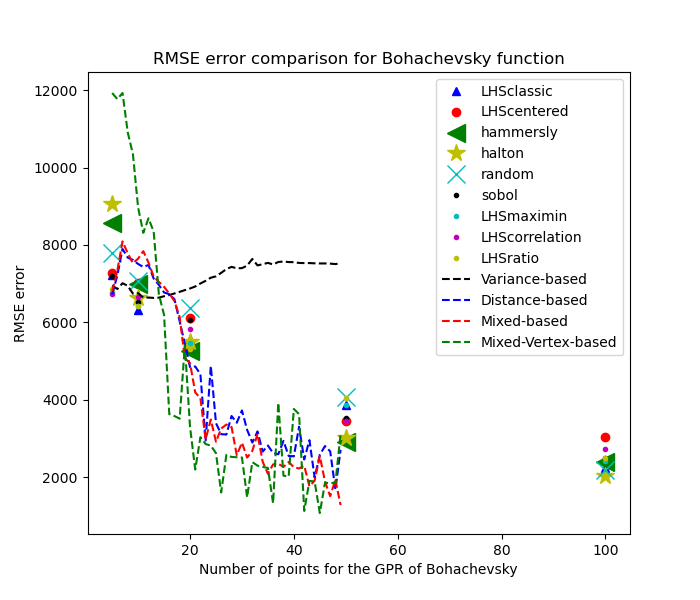

In [324]:
fig, ax = plt.subplots(figsize=(7,6))
iter = np.arange(0, 49, 1, dtype=int)

p1, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'LHSclassic')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'LHSclassic')].mse), "b^", label="LHSclassic")
p2, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'LHScentered')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'LHScentered')].mse), "ro", label="LHScentered")
p3, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'hammersly')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'hammersly')].mse), "g<", label="hammersly", ms=13, lw=2)
p4, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'halton')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'halton')].mse), "y*", label="halton", ms=13, lw=2)
p5, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'random')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'random')].mse), "cx", label="random", ms=13, lw=2)
p6, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'sobol')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'sobol')].mse), "k.", label="sobol")
p7, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'LHSmaximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'LHSmaximin')].mse), "c.", label="LHSmaximin")
p8, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'LHScorrelation')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'LHScorrelation')].mse), "m.", label="LHScorrelation")
p9, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'LHSratio')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'LHSratio')].mse), "y.", label="LHSratio")
p10, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'variance-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'variance-based maximin')].mse), "k--", label="Variance-based")
p11, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'distance-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'distance-based maximin')].mse), "b--", label="Distance-based")
p12, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'mixed-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'mixed-based maximin')].mse), "r--", label="Mixed-based")
p13, = ax.plot(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'mixed-based vertex')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'bohachevsky') & (df_errors['method'] == 'mixed-based vertex')].mse), "g--", label="Mixed-Vertex-based")
ax.set_xlabel("Number of points for the GPR of Bohachevsky")
ax.set_ylabel("RMSE error")
ax.legend()
ax.set_title("RMSE error comparison for Bohachevsky function")
plt.savefig('one-shot-bohachevsky.svg')

<IPython.core.display.Javascript object>


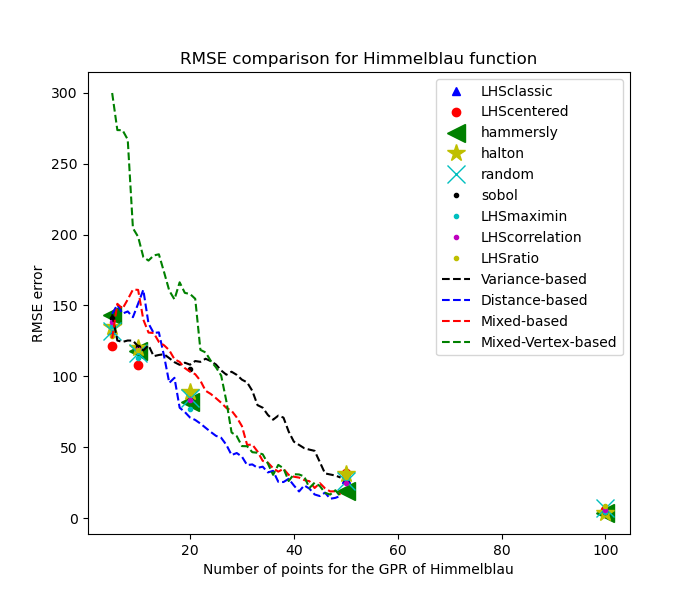

In [323]:
fig, ax = plt.subplots(figsize=(7,6))
iter = np.arange(0, 49, 1, dtype=int)

p1, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'LHSclassic')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'LHSclassic')].mse), "b^", label="LHSclassic")
p2, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'LHScentered')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'LHScentered')].mse), "ro", label="LHScentered")
p3, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'hammersly')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'hammersly')].mse), "g<", label="hammersly", ms=13, lw=2)
p4, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'halton')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'halton')].mse), "y*", label="halton", ms=13, lw=2)
p5, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'random')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'random')].mse), "cx", label="random", ms=13, lw=2)
p6, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'sobol')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'sobol')].mse), "k.", label="sobol")
p7, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'LHSmaximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'LHSmaximin')].mse), "c.", label="LHSmaximin")
p8, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'LHScorrelation')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'LHScorrelation')].mse), "m.", label="LHScorrelation")
p9, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'LHSratio')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'LHSratio')].mse), "y.", label="LHSratio")
p10, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'variance-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'variance-based maximin')].mse), "k--", label="Variance-based")
p11, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'distance-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'distance-based maximin')].mse), "b--", label="Distance-based")
p12, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'mixed-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'mixed-based maximin')].mse), "r--", label="Mixed-based")
p13, = ax.plot(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'mixed-based vertex')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'himmelblau') & (df_errors['method'] == 'mixed-based vertex')].mse), "g--", label="Mixed-Vertex-based")

ax.set_xlabel("Number of points for the GPR of Himmelblau")
ax.set_ylabel("RMSE error")
ax.set_title("RMSE comparison for Himmelblau function")
ax.legend()
plt.savefig('one-shot-himmelblau.svg')

<IPython.core.display.Javascript object>


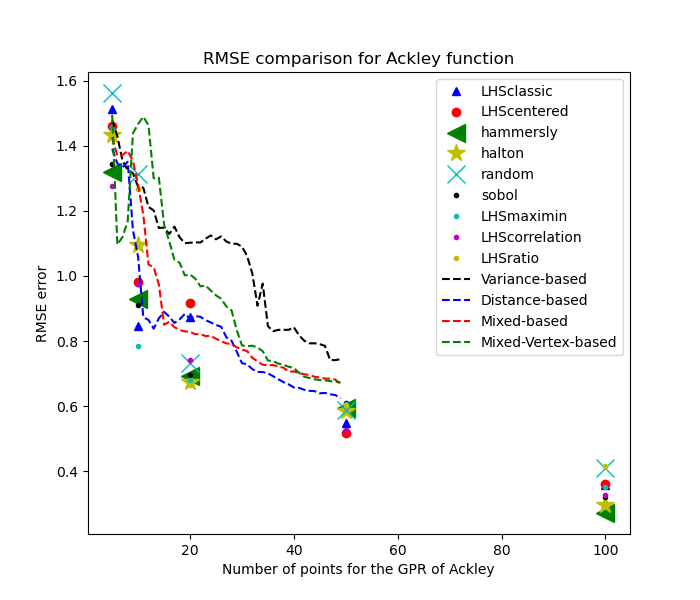

In [322]:
fig, ax = plt.subplots(figsize=(7,6))
iter = np.arange(0, 49, 1, dtype=int)

p1, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'LHSclassic')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'LHSclassic')].mse), "b^", label="LHSclassic")
p2, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'LHScentered')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'LHScentered')].mse), "ro", label="LHScentered")
p3, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'hammersly')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'hammersly')].mse), "g<", label="hammersly", ms=13, lw=2)
p4, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'halton')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'halton')].mse), "y*", label="halton", ms=13, lw=2)
p5, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'random')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'random')].mse), "cx", label="random", ms=13, lw=2)
p6, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'sobol')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'sobol')].mse), "k.", label="sobol")
p7, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'LHSmaximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'LHSmaximin')].mse), "c.", label="LHSmaximin")
p8, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'LHScorrelation')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'LHScorrelation')].mse), "m.", label="LHScorrelation")
p9, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'LHSratio')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'LHSratio')].mse), "y.", label="LHSratio")
p10, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'variance-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'variance-based maximin')].mse), "k--", label="Variance-based")
p11, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'distance-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'distance-based maximin')].mse), "b--", label="Distance-based")
p12, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'mixed-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'mixed-based maximin')].mse), "r--", label="Mixed-based")
p13, = ax.plot(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'mixed-based vertex')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'ackley') & (df_errors['method'] == 'mixed-based vertex')].mse), "g--", label="Mixed-Vertex-based")

ax.set_xlabel("Number of points for the GPR of Ackley")
ax.set_ylabel("RMSE error")
ax.set_title("RMSE comparison for Ackley function")
ax.legend()
plt.savefig('one-shot-ackley.svg')

<IPython.core.display.Javascript object>


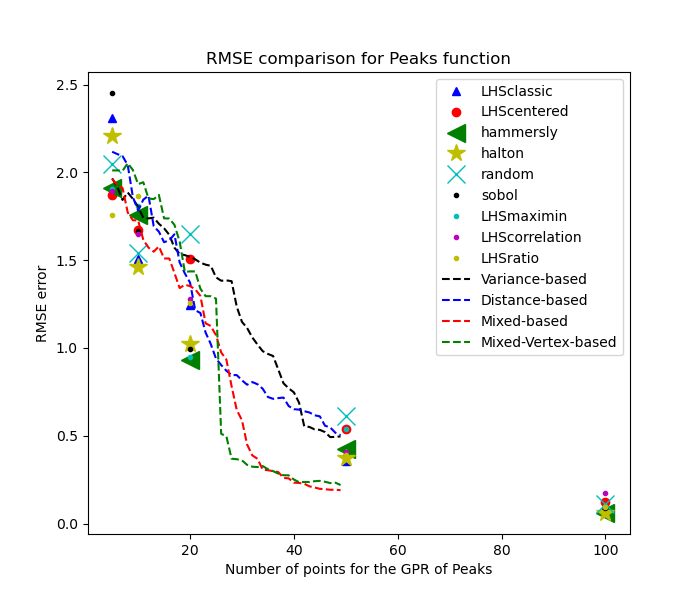

In [321]:
fig, ax = plt.subplots(figsize=(7,6))
iter = np.arange(0, 49, 1, dtype=int)

p1, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'LHSclassic')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'LHSclassic')].mse), "b^", label="LHSclassic")
p2, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'LHScentered')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'LHScentered')].mse), "ro", label="LHScentered")
p3, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'hammersly')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'hammersly')].mse), "g<", label="hammersly", ms=13, lw=2)
p4, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'halton')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'halton')].mse), "y*", label="halton", ms=13, lw=2)
p5, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'random')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'random')].mse), "cx", label="random", ms=13, lw=2)
p6, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'sobol')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'sobol')].mse), "k.", label="sobol")
p7, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'LHSmaximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'LHSmaximin')].mse), "c.", label="LHSmaximin")
p8, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'LHScorrelation')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'LHScorrelation')].mse), "m.", label="LHScorrelation")
p9, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'LHSratio')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'LHSratio')].mse), "y.", label="LHSratio")
p10, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'variance-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'variance-based maximin')].mse), "k--", label="Variance-based")
p11, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'distance-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'distance-based maximin')].mse), "b--", label="Distance-based")
p12, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'mixed-based maximin')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'mixed-based maximin')].mse), "r--", label="Mixed-based")
p13, = ax.plot(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'mixed-based vertex')].number_of_points, np.sqrt(df_errors.loc[(df_errors['function'] == 'peaks') & (df_errors['method'] == 'mixed-based vertex')].mse), "g--", label="Mixed-Vertex-based")

ax.set_xlabel("Number of points for the GPR of Peaks")
ax.set_ylabel("RMSE error")
ax.set_title("RMSE comparison for Peaks function")
ax.legend()
plt.savefig('one-shot-peaks.svg')

In [142]:
x_himmelblau_mixed = np.fromstring(df_mixed_based_maximin4.loc[(df_mixed_based_maximin4['function'] == 'himmelblau')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_himmelblau_mixed = np.fromstring(df_mixed_based_maximin4.loc[(df_mixed_based_maximin4['function'] == 'himmelblau')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_himmelblau_distance = np.fromstring(df_distance_based_maximin4.loc[(df_distance_based_maximin4['function'] == 'himmelblau')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_himmelblau_distance = np.fromstring(df_distance_based_maximin4.loc[(df_distance_based_maximin4['function'] == 'himmelblau')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_himmelblau_variance = np.fromstring(df_variance_based_maximin4.loc[(df_variance_based_maximin4['function'] == 'himmelblau')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_himmelblau_variance = np.fromstring(df_variance_based_maximin4.loc[(df_variance_based_maximin4['function'] == 'himmelblau')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_ackley_mixed = np.fromstring(df_mixed_based_maximin4.loc[(df_mixed_based_maximin4['function'] == 'ackley')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_ackley_mixed = np.fromstring(df_mixed_based_maximin4.loc[(df_mixed_based_maximin4['function'] == 'ackley')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_ackley_distance = np.fromstring(df_distance_based_maximin4.loc[(df_distance_based_maximin4['function'] == 'ackley')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_ackley_distance = np.fromstring(df_distance_based_maximin4.loc[(df_distance_based_maximin4['function'] == 'ackley')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_ackley_variance = np.fromstring(df_variance_based_maximin4.loc[(df_variance_based_maximin4['function'] == 'ackley')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_ackley_variance = np.fromstring(df_variance_based_maximin4.loc[(df_variance_based_maximin4['function'] == 'ackley')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_peaks_mixed = np.fromstring(df_mixed_based_maximin4.loc[(df_mixed_based_maximin4['function'] == 'peaks')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_peaks_mixed = np.fromstring(df_mixed_based_maximin4.loc[(df_mixed_based_maximin4['function'] == 'peaks')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_peaks_distance = np.fromstring(df_distance_based_maximin4.loc[(df_distance_based_maximin4['function'] == 'peaks')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_peaks_distance = np.fromstring(df_distance_based_maximin4.loc[(df_distance_based_maximin4['function'] == 'peaks')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_peaks_variance = np.fromstring(df_variance_based_maximin4.loc[(df_variance_based_maximin4['function'] == 'peaks')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_peaks_variance = np.fromstring(df_variance_based_maximin4.loc[(df_variance_based_maximin4['function'] == 'peaks')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_bohachevsky_mixed = np.fromstring(df_mixed_based_maximin4.loc[(df_mixed_based_maximin4['function'] == 'bohachevsky')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_bohachevsky_mixed = np.fromstring(df_mixed_based_maximin4.loc[(df_mixed_based_maximin4['function'] == 'bohachevsky')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_bohachevsky_distance = np.fromstring(df_distance_based_maximin4.loc[(df_distance_based_maximin4['function'] == 'bohachevsky')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_bohachevsky_distance = np.fromstring(df_distance_based_maximin4.loc[(df_distance_based_maximin4['function'] == 'bohachevsky')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')

x_bohachevsky_variance = np.fromstring(df_variance_based_maximin4.loc[(df_variance_based_maximin4['function'] == 'bohachevsky')].X_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')
y_bohachevsky_variance = np.fromstring(df_variance_based_maximin4.loc[(df_variance_based_maximin4['function'] == 'bohachevsky')].Y_new.iloc[-1].replace("\n", "").replace("[","").replace("]","").replace("     "," ").replace("   "," ").replace("  "," "), dtype=float, sep=' ')




<IPython.core.display.Javascript object>


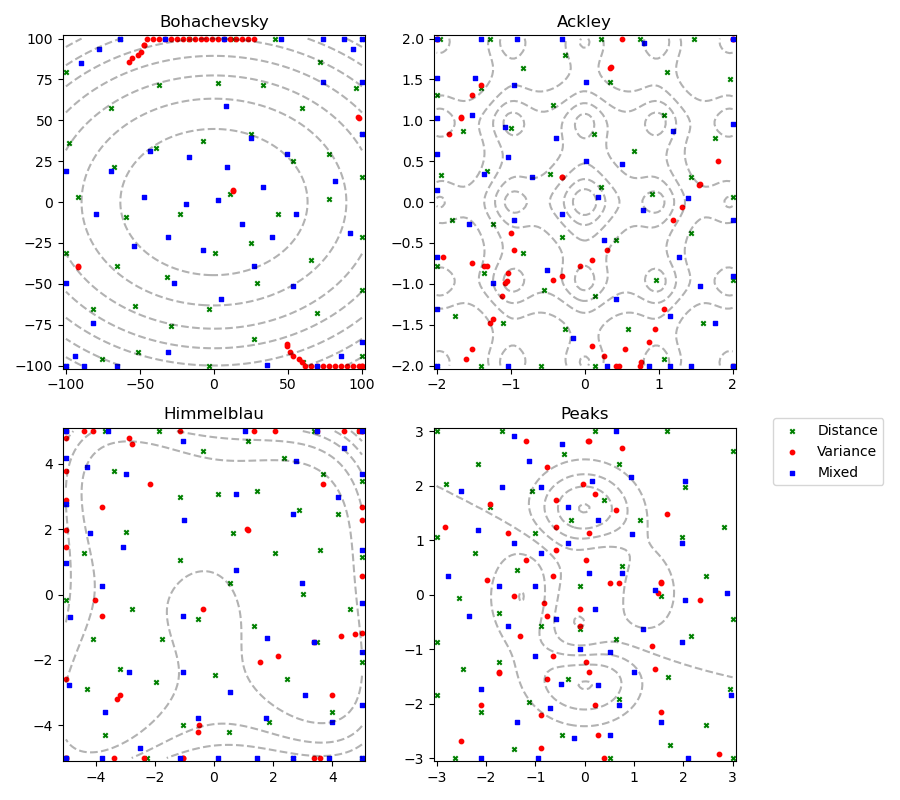

In [325]:
fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

r_min,r_max=-100,100
xaxis=np.linspace(r_min,r_max,500)
yaxis=np.linspace(r_min,r_max,500)

x,y=np.meshgrid(xaxis,yaxis)
results=bohachevsky(x,y)

ax1.contour(x, y, results, colors='black', alpha=0.3, linestyles='dashed');
ax1.scatter(x_bohachevsky_distance, y_bohachevsky_distance, s=10, c='g', marker="x", label='Distance')
ax1.scatter(x_bohachevsky_variance, y_bohachevsky_variance, s=10, c='r', marker="o", label='Variance')
ax1.scatter(x_bohachevsky_mixed, y_bohachevsky_mixed, s=10, c='b', marker="s", label='Mixed')
ax1.set_title("Bohachevsky")
ax1.set_xlim([r_min*1.02,r_max*1.02])
ax1.set_ylim([r_min*1.02,r_max*1.02])

r_min, r_max = -2.0, 2.0
xaxis = np.linspace(r_min, r_max, 100)
yaxis = np.linspace(r_min, r_max, 100)

x, y = meshgrid(xaxis, yaxis)
results = ackley(x, y)

ax2.contour(x, y, results, colors='black', alpha=0.3, linestyles='dashed');
ax2.scatter(x_ackley_distance, y_ackley_distance, s=10, c='g', marker="x", label='Distance')
ax2.scatter(x_ackley_variance, y_ackley_variance, s=10, c='r', marker="o", label='Variance')
ax2.scatter(x_ackley_mixed, y_ackley_mixed, s=10, c='b', marker="s", label='Mixed')
ax2.set_title("Ackley")
ax2.set_xlim([r_min*1.02,r_max*1.02])
ax2.set_ylim([r_min*1.02,r_max*1.02])

r_min, r_max = -5.0, 5.0
xaxis = np.linspace(r_min, r_max, 100)
yaxis = np.linspace(r_min, r_max, 100)

x, y = meshgrid(xaxis, yaxis)
results = himmelblau(x, y)

ax3.contour(x, y, results, colors='black', alpha=0.3, linestyles='dashed');
ax3.scatter(x_himmelblau_distance, y_himmelblau_distance, s=10, c='g', marker="x", label='Distance')
ax3.scatter(x_himmelblau_variance, y_himmelblau_variance, s=10, c='r', marker="o", label='Variance')
ax3.scatter(x_himmelblau_mixed, y_himmelblau_mixed, s=10, c='b', marker="s", label='Mixed')
ax3.set_title("Himmelblau")
ax3.set_xlim([r_min*1.02,r_max*1.02])
ax3.set_ylim([r_min*1.02,r_max*1.02])

r_min, r_max = -3.0, 3.0
xaxis = np.linspace(r_min, r_max, 100)
yaxis = np.linspace(r_min, r_max, 100)

x, y = meshgrid(xaxis, yaxis)
results = peaks(x, y)

ax4.contour(x, y, results, colors='black', alpha=0.3, linestyles='dashed');
ax4.scatter(x_peaks_distance, y_peaks_distance, s=10, c='g', marker="x", label='Distance')
ax4.scatter(x_peaks_variance, y_peaks_variance, s=10, c='r', marker="o", label='Variance')
ax4.scatter(x_peaks_mixed, y_peaks_mixed, s=10, c='b', marker="s", label='Mixed')
ax4.set_title("Peaks")
ax4.set_xlim([r_min*1.02,r_max*1.02])
ax4.set_ylim([r_min*1.02,r_max*1.02])

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.show()
plt.savefig('distribution-comparison.svg')


49

# Variance-based Active Learning (Maximin Starting Criteria)

If we run this algorithm with Maximin method, all the first points are suggested in points where we already have existing points.

In [173]:
array_results = []

column_names = ["number_of_points", "method", "function", "mse", "X_new", "Y_new"]

functions = ["bohachevsky", "ackley", "himmelblau", "peaks"]

for function in functions:
    if function == "peaks":
        r_min, r_max = -3.0, 3.0
    elif function == "bohachevsky":
        r_min, r_max = -100.0, 100.0
    elif function == "ackley":
        r_min, r_max = -2.0, 2.0
    elif function == "himmelblau":
        r_min, r_max = -5.0, 5.0
    else:
        print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
        break;
                
    xaxis = np.linspace(r_min, r_max, 100)
    yaxis = np.linspace(r_min, r_max, 100)

    x, y = meshgrid(xaxis, yaxis)
    X_new, Y_new = latin_sampler_optimizer(5, r_min, r_max, 'maximin')
    if function == "peaks":
        z = peaks(X_new, Y_new)
    elif function == "bohachevsky":
        z = bohachevsky(X_new, Y_new)
    elif function == "ackley":
        z = ackley(X_new, Y_new)
    elif function == "himmelblau":
        z = himmelblau(X_new, Y_new)
    else:
        print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
        break;

    print("Function: "+function+". r_min, r_max = "+str(r_min)+", "+str(r_max))
                
    for iters in range(0, 45):
        if function == "peaks":
            z = peaks(X_new, Y_new)
        elif function == "bohachevsky":
            z = bohachevsky(X_new, Y_new)
        elif function == "ackley":
            z = ackley(X_new, Y_new)
        elif function == "himmelblau":
            z = himmelblau(X_new, Y_new)
        else:
            print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
            break;

        x_train = np.column_stack((X_new,Y_new))
        y_train = z
        print("Len x_train: "+str(len(x_train))) 
        print("Len y_train: "+str(len(y_train))) 

        # K-Folding
        cumulative_sum = np.zeros(len(xaxis)*len(yaxis))
        for j in range(0,len(x_train)):
            globals()[f'X_train_{j}'] = np.delete(x_train, j, axis=0)
            globals()[f'Y_train_{j}'] = np.delete(y_train, j, axis=0)
            globals()[f'gaussian_process_{j}'] = gpr_train(globals()[f'X_train_{j}'], globals()[f'Y_train_{j}'])
            globals()[f'mean_prediction_{j}'], globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'] = predict(globals()[f'gaussian_process_{j}'], x, y, False)
            cumulative_sum += globals()[f'mean_prediction_{j}']
            
        mean_prediction_kfolding = cumulative_sum/len(x_train) 
        
        if function == "peaks":
            actual_value = peaks(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        elif function == "bohachevsky":
            actual_value = bohachevsky(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        elif function == "ackley":
            actual_value = ackley(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        elif function == "himmelblau":
            actual_value = himmelblau(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        else:
            print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
            break;
        
        iter_mse = mse(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], actual_value, mean_prediction_kfolding)

        cumulative_variance = np.zeros(len(xaxis)*len(yaxis))
        for j in range(0,len(x_train)):
            cumulative_variance += (globals()[f'mean_prediction_{j}']-mean_prediction_kfolding)**2
        variance = cumulative_variance/len(x_train)

        variances_array = np.column_stack((globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], np.sqrt(variance)))
        max_variance_x, max_variance_y, max_variance = variances_array[variances_array[:,2].argmax(),:]

        print("Max variances: "+str(max_variance))
        print("Max variance x: "+str(max_variance_x))
        print("Max variance y: "+str(max_variance_y))
        print("MSE: "+str(iter_mse))

        
        gaussian_process = gpr_train(globals()[f'X_train_{j}'], globals()[f'Y_train_{j}'])
        mean_prediction_result, x_coord, y_coord = predict(gaussian_process, x, y, False)
        errores_mse = mse(x_coord, y_coord, actual_value, mean_prediction_result)
        
        array_results.append([len(X_new), 'variance-based maximin', function, errores_mse, X_new, Y_new])
        
        
        X_new = np.append(X_new, max_variance_x)
        Y_new = np.append(Y_new, max_variance_y)
        
        
        iters+=1
        
#df_variance_based_maximin = pd.DataFrame(array_results, columns = column_names)
#df_variance_based_maximin.to_csv('variance_based_maximin_run_5.csv')
    

Generated 5 with LHS optimizer maximin
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4396.193333444058
Max variance x: -55.55555555555555
Max variance y: 87.8787878787879
MSE: 45707334.37438074


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5393.326753888672
Max variance x: -7.0707070707070585
Max variance y: -1.0101010101010104
MSE: 45055603.145158105


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 3032.4276640619396
Max variance x: 19.191919191919197
Max variance y: -93.93939393939394
MSE: 43181033.76203467


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1611.2433898400197
Max variance x: -89.8989898989899
Max variance y: -57.57575757575757
MSE: 43329807.3341569


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 467.131154910405
Max variance x: -1.0101010101010104
Max variance y: -3.030303030303031
MSE: 43885640.2073226


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1828.9998044982888
Max variance x: 1.0101010101010104
Max variance y: -3.030303030303031
MSE: 41120520.32914222


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 424.11423098937325
Max variance x: 81.81818181818184
Max variance y: 45.45454545454547
MSE: 40762538.50424336


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 12
Len y_train: 12


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 403.18183663923355
Max variance x: 5.050505050505052
Max variance y: -3.030303030303031
MSE: 40714648.6094241


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 625.3235387877197
Max variance x: 9.090909090909093
Max variance y: -3.030303030303031
MSE: 40638703.162553266


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 604.9048888515432
Max variance x: 13.131313131313135
Max variance y: -3.030303030303031
MSE: 40686215.267307736


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 15
Len y_train: 15


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 565.4419951801908
Max variance x: 17.171717171717177
Max variance y: -3.030303030303031
MSE: 40844886.016646914


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 522.2054601771337
Max variance x: 21.212121212121218
Max variance y: -3.030303030303031
MSE: 41093317.11409486


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 481.4729546902366
Max variance x: 25.25252525252526
Max variance y: -3.030303030303031
MSE: 41410924.08520339


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 442.09306128559854
Max variance x: 29.2929292929293
Max variance y: -3.030303030303031
MSE: 41779716.750987574


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 404.05964496769184
Max variance x: 33.33333333333334
Max variance y: -3.030303030303031
MSE: 42183200.52996618


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 367.12239426727155
Max variance x: 37.373737373737384
Max variance y: -3.030303030303031
MSE: 42606544.164169975


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

Max variances: 331.12674698462655
Max variance x: 41.414141414141426
Max variance y: -3.030303030303031
MSE: 43036311.51696913


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 295.9299726553145
Max variance x: 45.45454545454547
Max variance y: -3.030303030303031
MSE: 43460380.036142394


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 2419.2083648138782
Max variance x: 100.0
Max variance y: -47.474747474747474
MSE: 59306024.3111457


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 2607.2591247104483
Max variance x: 100.0
Max variance y: -47.474747474747474
MSE: 40946829.60023031


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 25
Len y_train: 25


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133:

Max variances: 286.9926695344236
Max variance x: 49.49494949494951
Max variance y: -3.030303030303031
MSE: 40648519.74049039


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 26
Len y_train: 26


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


  ascent direction in projection gd =    0.0000000000000000     


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 254.00362501805904
Max variance x: 53.53535353535355
Max variance y: -3.030303030303031
MSE: 40893698.03252952


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 27
Len y_train: 27


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/lib/python3/dis

Max variances: 243.78717296103926
Max variance x: -59.59595959595959
Max variance y: 91.91919191919195
MSE: 41131193.85517029


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 28
Len y_train: 28


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 905.167743949831
Max variance x: -61.61616161616161
Max variance y: 93.93939393939394
MSE: 39488379.81831608


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 29
Len y_train: 29


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.2293862558572797E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 573.283989454523
Max variance x: -63.63636363636363
Max variance y: 95.95959595959596
MSE: 38609211.451534055


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 30
Len y_train: 30


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 3113.2318292200735
Max variance x: 17.171717171717177
Max variance y: 27.27272727272728
MSE: 37263934.29020943


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 31
Len y_train: 31


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 2265.049245325813
Max variance x: 100.0
Max variance y: 100.0
MSE: 39166584.38835936


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 32
Len y_train: 32


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 4607.70190447892
Max variance x: 100.0
Max variance y: 100.0
MSE: 26167497.92139532


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 33
Len y_train: 33


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

  ascent direction in projection gd =    0.0000000000000000     


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 2669.1744344302147
Max variance x: -13.13131313131312
Max variance y: 23.23232323232324
MSE: 25953326.444137834


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 34
Len y_train: 34


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 1655.3005146420767
Max variance x: -33.33333333333333
Max variance y: -5.050505050505038
MSE: 26213798.338503845


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 35
Len y_train: 35


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res

Max variances: 3176.1737972470473
Max variance x: 97.97979797979798
Max variance y: 100.0
MSE: 26423936.875408135


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 36
Len y_train: 36


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 1694.3440478448617
Max variance x: -7.0707070707070585
Max variance y: -27.272727272727266
MSE: 26633872.272639357


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 37
Len y_train: 37


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/ga

Max variances: 1123.0639663581671
Max variance x: 100.0
Max variance y: 77.7777777777778
MSE: 26954140.30053913


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).

Len x_train: 38
Len y_train: 38


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 970.4882197365416
Max variance x: 100.0
Max variance y: 77.7777777777778
MSE: 26190093.458142903


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 449.07709941706526
Max variance x: -67.67676767676767
Max variance y: 100.0
MSE: 26177742.91505779


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 40
Len y_train: 40


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

  ascent direction in projection gd =    2.9240832580730613E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 806.2277398077083
Max variance x: -69.69696969696969
Max variance y: 100.0
MSE: 24829485.97902902


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 41
Len y_train: 41


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.1652625834148402E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res

  ascent direction in projection gd =    5.6461843503602872E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 255.7998217496284
Max variance x: -33.33333333333333
Max variance y: -5.050505050505038
MSE: 24531304.65566503


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 42
Len y_train: 42


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.7522758188773333E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 245.59327558815107
Max variance x: -73.73737373737373
Max variance y: 100.0
MSE: 24540952.147892367


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 43
Len y_train: 43


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 524.9586068149673
Max variance x: -77.77777777777777
Max variance y: 100.0
MSE: 23868594.27606312


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 44
Len y_train: 44


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 520.1959696156997
Max variance x: -81.81818181818181
Max variance y: 100.0
MSE: 23314830.685667872


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 45
Len y_train: 45


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 526.6315368190786
Max variance x: -85.85858585858585
Max variance y: 100.0
MSE: 22858795.518549047


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 46
Len y_train: 46


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 524.216207239376
Max variance x: -89.8989898989899
Max variance y: 100.0
MSE: 22512113.794700895


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 47
Len y_train: 47


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 526.1821629205053
Max variance x: -93.93939393939394
Max variance y: 100.0
MSE: 22270203.71197759


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 48
Len y_train: 48


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 529.5077239774506
Max variance x: -97.97979797979798
Max variance y: 100.0
MSE: 22127055.915762167


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 49
Len y_train: 49


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 512.3002394116107
Max variance x: -100.0
Max variance y: 100.0
MSE: 22064457.460782886


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS optimizer maximin
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.7431047634798589
Max variance x: 0.9090909090909092
Max variance y: 1.1111111111111112
MSE: 2.0209118234164762


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.4986081310582138
Max variance x: 0.9090909090909092
Max variance y: 1.0303030303030307
MSE: 2.014940218902071


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.40622267387261174
Max variance x: 1.9595959595959598
Max variance y: -0.7474747474747474
MSE: 1.9870266085625494


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.22804957998555933
Max variance x: 0.9090909090909092
Max variance y: 0.666666666666667
MSE: 1.9502415756144804


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.16637316443538683
Max variance x: 0.14141414141414144
Max variance y: -1.7171717171717171
MSE: 1.9592419186897088


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.11796007843692885
Max variance x: 0.9494949494949498
Max variance y: 0.5858585858585861
MSE: 1.944456664934402


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.304105792101073
Max variance x: 0.9090909090909092
Max variance y: 1.5959595959595965
MSE: 1.9405055559228261


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 12
Len y_train: 12


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

Max variances: 0.2853377193165565
Max variance x: 0.9090909090909092
Max variance y: 1.6363636363636367
MSE: 1.8627195794634372


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.10657586637079776
Max variance x: -1.2323232323232323
Max variance y: -0.3434343434343432
MSE: 1.857854251161412


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to c

Max variances: 0.14755353880185104
Max variance x: -1.3131313131313131
Max variance y: -0.5858585858585856
MSE: 1.8274956615316071


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 15
Len y_train: 15


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

Max variances: 0.09447429734886678
Max variance x: -1.1515151515151514
Max variance y: -0.06060606060606055
MSE: 1.813672567462938


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.4932014613866152
Max variance x: -1.1111111111111112
Max variance y: 0.22222222222222232
MSE: 1.8898296151602145


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.28628485973562
Max variance x: -2.0
Max variance y: 2.0
MSE: 1.7807067748144152


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.27456247415055185
Max variance x: -2.0
Max variance y: 2.0
MSE: 1.6536695751511892


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 19
Len y_train: 19


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.17161648812099087
Max variance x: -1.1515151515151514
Max variance y: -0.06060606060606055
MSE: 1.6501634477551907


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 20
Len y_train: 20


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.12217854353678549
Max variance x: -1.0707070707070705
Max variance y: 0.3838383838383841
MSE: 1.6504917275663695


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 21
Len y_train: 21


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.06416942519915046
Max variance x: 0.9090909090909092
Max variance y: 1.9191919191919196
MSE: 1.6511725377659565


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 22
Len y_train: 22


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.11531034167305435
Max variance x: 0.9090909090909092
Max variance y: 2.0
MSE: 1.6722398137790941


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.05220185544572424
Max variance x: 1.070707070707071
Max variance y: 0.3838383838383841
MSE: 1.6702533424411605


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.06847411239048956
Max variance x: 1.1515151515151518
Max variance y: 0.262626262626263
MSE: 1.6488710184630355


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 25
Len y_train: 25


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.06254766950856512
Max variance x: 1.272727272727273
Max variance y: 0.10101010101010122
MSE: 1.6344047937068353


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.04747340525913883
Max variance x: -0.10101010101010077
Max variance y: -1.5151515151515151
MSE: 1.6283576609513204


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 27
Len y_train: 27


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.04662326463082458
Max variance x: 0.3838383838383841
Max variance y: -1.9191919191919191
MSE: 1.634482422859456


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 28
Len y_train: 28


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.12966286024191573
Max variance x: 0.5050505050505052
Max variance y: -2.0
MSE: 1.6047940095810915


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 29
Len y_train: 29


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.21318897770083187
Max variance x: 2.0
Max variance y: -2.0
MSE: 1.569635992976518


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 30
Len y_train: 30


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.17086399906095148
Max variance x: -0.303030303030303
Max variance y: 0.868686868686869
MSE: 1.5238866229701118


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.35534213786807545
Max variance x: -2.0
Max variance y: -2.0
MSE: 1.210489916072283


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 32
Len y_train: 32


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.25119113954085925
Max variance x: -0.303030303030303
Max variance y: 0.868686868686869
MSE: 1.147844568926474


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 33
Len y_train: 33


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.17591250586069848
Max variance x: 0.22222222222222232
Max variance y: -0.2222222222222221
MSE: 1.1396768221825093


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 34
Len y_train: 34


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.3698283738442899
Max variance x: 0.22222222222222232
Max variance y: -0.2222222222222221
MSE: 0.7268006494573053


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 35
Len y_train: 35


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.19972266083652668
Max variance x: -1.1515151515151514
Max variance y: 0.868686868686869
MSE: 0.7210685919665986


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 36
Len y_train: 36


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.18808992132848454
Max variance x: 2.0
Max variance y: 2.0
MSE: 0.7499173204184943


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.14807405001071627
Max variance x: -2.0
Max variance y: -2.0
MSE: 0.7327077013239015


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 38
Len y_train: 38


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.12864108264496105
Max variance x: -1.393939393939394
Max variance y: -0.7878787878787878
MSE: 0.7347735576082206


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 39
Len y_train: 39


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.11864146397130482
Max variance x: 1.1515151515151518
Max variance y: 1.1111111111111112
MSE: 0.7301544839667403


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 40
Len y_train: 40


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.14979284544742968
Max variance x: 0.666666666666667
Max variance y: 1.1515151515151518
MSE: 0.650599557520909


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 41
Len y_train: 41


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.1267753641588607
Max variance x: 1.3131313131313136
Max variance y: 1.1111111111111112
MSE: 0.6563550821030988


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 42
Len y_train: 42


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.10030724340934127
Max variance x: 2.0
Max variance y: -2.0
MSE: 0.6399831289247442


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 43
Len y_train: 43


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.08450782665024012
Max variance x: 1.5151515151515156
Max variance y: 1.1111111111111112
MSE: 0.6407983411240561


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 44
Len y_train: 44


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.0818875905868202
Max variance x: 0.5454545454545459
Max variance y: 0.6262626262626263
MSE: 0.6216505545702063


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 45
Len y_train: 45


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.07064259916883678
Max variance x: 2.0
Max variance y: 2.0
MSE: 0.6349933939234143


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 46
Len y_train: 46


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.06641742885809544
Max variance x: 0.9090909090909092
Max variance y: 1.393939393939394
MSE: 0.6353601634168755


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 47
Len y_train: 47


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.055844440503676034
Max variance x: 1.7575757575757578
Max variance y: 1.1111111111111112
MSE: 0.6386267444129841


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 48
Len y_train: 48


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

Max variances: 0.053606166752163203
Max variance x: -0.2222222222222221
Max variance y: -1.393939393939394
MSE: 0.6446931589218234


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 49
Len y_train: 49


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 0.04837644478605925
Max variance x: 0.7474747474747478
Max variance y: -2.0
MSE: 0.6428749647325559


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS optimizer maximin
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 117.53062915603586
Max variance x: 3.0808080808080813
Max variance y: 4.8989898989899
MSE: 13484.063317411292


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 106.77008955519221
Max variance x: -1.3636363636363638
Max variance y: -4.191919191919192
MSE: 13911.417710974472


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 64.37944305293172
Max variance x: 2.474747474747475
Max variance y: 4.09090909090909
MSE: 13053.90585989598


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 52.83251453185697
Max variance x: 3.4848484848484844
Max variance y: 5.0
MSE: 12239.369759078785


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 62.09984636998873
Max variance x: 4.191919191919192
Max variance y: 5.0
MSE: 12130.710096808834


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 116.13321621918516
Max variance x: 5.0
Max variance y: 5.0
MSE: 11087.865224143954


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

Max variances: 74.09271856214053
Max variance x: 5.0
Max variance y: 5.0
MSE: 11661.374255471967


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 12
Len y_train: 12
  ascent direction in projection gd =    2.0428367938018683E-020
  ascent direction in projection gd =    7.7179012977498338E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0128173309277967E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.9816276060422418E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.9351631980733253E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.0518127775013055E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 69.53132317726163
Max variance x: 1.0606060606060606
Max variance y: 2.474747474747475
MSE: 11991.920837778322


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    9.9115011402086841E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.8808868315283109E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.5076269700696160E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

Max variances: 58.24996325869257
Max variance x: 4.8989898989899
Max variance y: -2.3737373737373737
MSE: 12139.376066502831


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.0523263834406038E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.7779175958525455E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.8206912456963522E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.1273589671926435E-002


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 46.68520655774094
Max variance x: -4.292929292929293
Max variance y: 2.878787878787879
MSE: 12896.073376413588


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 15
Len y_train: 15
  ascent direction in projection gd =    1.6977436454283559E-006
  ascent direction in projection gd =    4.6487238438806679E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.1341325727861276E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.6161010661051825E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.0310320694138234E-008
  ascent direction in projection gd =    6.2800548850009097E-006
  ascent direction in projection gd =    4.1460890585904179E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max variances: 39.84601108215366
Max variance x: 3.1818181818181817
Max variance y: -2.474747474747475
MSE: 13053.863174234268


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    8.5975903927541150E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.4089628938214321E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    9.1972711698026468E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.3318237229446135E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0054883931051461E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 33.93500652206706
Max variance x: -2.5757575757575757
Max variance y: 2.9797979797979792
MSE: 13283.069123777464


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.7937999982412359E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.6586071747302475E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.2403435389451564E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.5958877554479939E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.3399670222227330E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

  ascent direction in projection gd =    1.6900664816782548E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 21.82386139140483
Max variance x: -0.6565656565656566
Max variance y: -2.5757575757575757
MSE: 13519.917027981597


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    9.2799534326279858E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.7881027023978588E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.7197353531678943E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.7240842751001711E-010
  ascent direction in projection gd =    6.1143383211756601E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 20.229097424114105
Max variance x: -5.0
Max variance y: 2.9797979797979792
MSE: 13753.420620839846


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.4692187342166255E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 25.865237095636008
Max variance x: -5.0
Max variance y: 4.292929292929292
MSE: 13481.403172560476


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0973949503228575E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.2320807618222374E-011
  ascent direction in projection gd =    5.1570280776924736E-002


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0957424321270470E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 17.42815576884654
Max variance x: -4.595959595959596
Max variance y: 5.0
MSE: 13197.6233291641


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.4727443223602002E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0273123190077003E-017
  ascent direction in projection gd =    9.3265462386615178E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 16.768361179354063
Max variance x: -5.0
Max variance y: 1.666666666666667
MSE: 13296.231899364311


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.1073262270024982E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.2148745586569297E-013
  ascent direction in projection gd =    1.9440440135169749E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.2109706920257484E-004
  ascent direction in projection gd =    3.3194875846592666E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.3602938955747637E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 27.3541417713335
Max variance x: -5.0
Max variance y: 0.3535353535353538
MSE: 15969.066621949603


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 23
Len y_train: 23
  ascent direction in projection gd =    3.5857808402909329E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.2693184669126569E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.7015109310704783E-016
  ascent direction in projection gd =    1.9794025038482959E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.2007866268992802E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.7838538605602788E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.7570474235423241E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.2513719937885991E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 14.624762341316007
Max variance x: -2.676767676767677
Max variance y: -5.0
MSE: 15376.31493894649
  ascent direction in projection gd =    5.9474011310880967E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 24
Len y_train: 24
  ascent direction in projection gd =    3.6186410745856180E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.2660817340758624E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0353364053098374E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.2067134142072476E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 17.12671770307314
Max variance x: -4.191919191919192
Max variance y: -5.0
MSE: 13131.042666575288


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 25
Len y_train: 25


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

  ascent direction in projection gd =    1.3040420114083392E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.0450588171635291E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.9059936610350594E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.8822693387728510E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.4779798411215016E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.5208494938297361E-013
  ascent direction in projection gd =    6.1632216720815244E-015
  ascent direction in projection gd =    3.5469017367119199E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 30.71239203986303
Max variance x: -5.0
Max variance y: -5.0
MSE: 10940.49444332139


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.5947598498112321E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 14.659076847426666
Max variance x: -5.0
Max variance y: -5.0
MSE: 10834.640827170972


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 27
Len y_train: 27
  ascent direction in projection gd =    1.0165871996748883E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.1562332733579041E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.6575834804276186E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.6934375516763198E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.2113741530121150E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.3407092161076653E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    5.6158573820460625E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    9.9816256196221728E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    6.8868076102171827E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.1036507292013574E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.7487486353201398E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 14.09877690416525
Max variance x: -3.9898989898989896
Max variance y: -4.898989898989899
MSE: 10822.982435802758


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 28
Len y_train: 28


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.5916708238583006E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    7.6127954835895417E-009
  ascent direction in projection gd =    1.2724291941895923E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.6088803030162544E-005
  ascent direction in projection gd =    1.0450363420762167E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.7315534794973402E-020


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0346055066826322E-008
  ascent direction in projection gd =    3.5218859857363448E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.9020838544757183E-010
  ascent direction in projection gd =    2.7609879439329828E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.2335768332993920E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.3966765876641636E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.9191202122848838E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.9882393188712904E-011
  ascent direction in projection gd =    3.3285953700583947E-016
  ascent direction in projection gd =    2.1629843387722282E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 18.70265403770612
Max variance x: -4.090909090909091
Max variance y: -3.383838383838384
MSE: 8586.913985709045


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 29
Len y_train: 29


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.0616428987641991E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0503075792819482E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.5077091906126283E-008
  ascent direction in projection gd =    2.9756500777874040E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.0200433609955946E-004
  ascent direction in projection gd =    1.5464026793582666E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.2278500531706459E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.3554792277727174E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.0567546737398696E-018
  ascent direction in projection gd =    3.5879864318251607E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 25.550454432409218
Max variance x: -4.191919191919192
Max variance y: -2.7777777777777777
MSE: 6912.971090293221


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 30
Len y_train: 30
  ascent direction in projection gd =    4.9382392814489526E-016
  ascent direction in projection gd =    8.0645242660120703E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    8.5727612630782626E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.3640856307064840E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.5926174314206406E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    9.8487068843359961E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.1499308076954935E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    6.1747916435399454E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.4820489490755738E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.8331128361567884E-008
  ascent direction in projection gd =    1.2116699775754149E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.2587197741602263E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    6.9467179397817754E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 12.852755802542106
Max variance x: 0.6565656565656566
Max variance y: 0.15151515151515138
MSE: 6818.647737814157


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.8698468328998683E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.2634349562473861E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.9691790484670847E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    7.0967902483942720E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.6174262251160651E-015
  ascent direction in projection gd =    1.0492420794584939E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.9147101489321790E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.4973304824276203E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.3540632255839381E-010
  ascent direction in projection gd =    1.1199913371378216E-015
  ascent direction in projection gd =    1.7254233942616376E-020
  ascent direction in projection gd =    1.8560725618282669E-020


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.6159905292894926E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.0317879183382128E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.3689775464317409E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.6933002648662361E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.3423030994371447E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.9295772771771528E-011
  ascent direction in projection gd =    5.3907918482353727E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max variances: 57.54107174705999
Max variance x: 3.9898989898989896
Max variance y: 2.474747474747475
MSE: 6386.043361146314
  ascent direction in projection gd =    5.7869773435605212E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 32
Len y_train: 32


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.1740376771291698E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.4747221276802649E-016
  ascent direction in projection gd =    9.6547721458002059E-003


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.4697470587627641E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.9588036964377484E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.0894266954904918E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =   0.16183811187886823     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.3380960953588601E-005
  ascent direction in projection gd =    2.9590651755325241E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.1636205386761000E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.1789063193197172E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.5700457470056565E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.8797986808999091E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    5.7905830552266303E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 72.88805019068097
Max variance x: 0.050505050505050164
Max variance y: 5.0
MSE: 3275.140668884264


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 33
Len y_train: 33
  ascent direction in projection gd =    8.9746904691935426E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.3274789374676336E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.8754568543539576E-006
  ascent direction in projection gd =    7.4852321520637034E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.9595989021375481E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.4801983679850701E-006
  ascent direction in projection gd =    1.5598706143647206E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.3360190628735755E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.3110085926789620E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.0811753747728655E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.1819937682725366E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.8022771650608159E-012
  ascent direction in projection gd =    2.5739367947564194E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.2439614530153390E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =   0.12950966738923106     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.6371805260905438E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.2744759206272341E-019
  ascent direction in projection gd =    1.0221704229474602E-011
  ascent direction in projection gd =    6.4619054280074375E-010
  ascent direction in projection gd =    9.0150445517910362E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    9.3195700221873937E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.4897595244352142E-006
  ascent direction in projection gd =    2.1289070693647035E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 34.58538233296637
Max variance x: 1.7676767676767673
Max variance y: -4.191919191919192
MSE: 3445.325436763729


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.2488239550835817E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 34
Len y_train: 34


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.4765515347873055E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 26.841578993448717
Max variance x: 3.0808080808080813
Max variance y: -5.0
MSE: 1845.8188597824621
  ascent direction in projection gd =    9.4348572122510110E-012
  ascent direction in projection gd =    5.5564076729037678E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 35
Len y_train: 35


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.5473535898489207E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.2535274602013763E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    9.7119230846905043E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 52.809249243676334
Max variance x: 5.0
Max variance y: -5.0
MSE: 1967.2750251036434


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 36
Len y_train: 36


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.0780597703854161E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.1165611404940037E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max variances: 13.631289160863574
Max variance x: -2.9797979797979797
Max variance y: 5.0
MSE: 2422.986134419862
  ascent direction in projection gd =    2.7227373751387793E-008
  ascent direction in projection gd =    3.0305932800695008E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.0951767666331589E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.7797126345637323E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.7817786640128992E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.6896065406398781E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.1638433909796534E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.9392244833794478E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.8771634880167885E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 13.096300617943998
Max variance x: 5.0
Max variance y: 0.9595959595959593
MSE: 2347.236370107274


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 38
Len y_train: 38


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_19837

  ascent direction in projection gd =    1.0465826987043810E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.0839549247110398E-003


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.0969698737595013E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.2978685513273107E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.3388193060664019E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.8840326833446915E-003


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.9187351180691483E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 23.836681693598155
Max variance x: 3.5858585858585865
Max variance y: 2.3737373737373737
MSE: 1726.9606921877028


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.0635480875743649E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.1965151248038512E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.3241560350276326E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.6048377140453370E-003


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.9631281525576652E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.0775836024304177E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max variances: 24.77767732037258
Max variance x: 3.282828282828282
Max variance y: 0.45454545454545414
MSE: 1035.4917167007688


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 40
Len y_train: 40


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.4088533179768324E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.6485798274949944E-011
  ascent direction in projection gd =    2.8297260511579163E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.2447830497545557E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.0072312761477343E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0704062477607372E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.1105678414536387E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.6423447627246333E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 14.305606559719289
Max variance x: 5.0
Max variance y: 0.5555555555555554
MSE: 1028.6573168985176


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 41
Len y_train: 41
  ascent direction in projection gd =    4.7020603325375609E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.2237711006565691E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.4747269013977492E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    7.5321491297304078E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.6240011613113276E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.0661346515951023E-020


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.1849589872765707E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.0363726679502906E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0852238583002672E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.0904353501225068E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 11.62578913008595
Max variance x: 5.0
Max variance y: -5.0
MSE: 981.9129465989481


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 42
Len y_train: 42
  ascent direction in projection gd =    5.8374610090943214E-019
  ascent direction in projection gd =    6.1784573158013551E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.3275845632513633E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.1617283339309014E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.1015224976550492E-015
  ascent direction in projection gd =    2.6641579344551287E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.4494024423858847E-007
  ascent direction in projection gd =    1.1216361093773735E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    6.6360619951278483E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.4677518669882252E-015
  ascent direction in projection gd =    2.2916022963978981E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.7843689858799167E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    6.7223216200837842E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.2343832345210874E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.4025546981312844E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.1060539478186673E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.1087446817653490E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.4275269430744063E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0280324186052871E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.6751167960673313E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    5.7205067014073603E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.6934348745532180E-017
  ascent direction in projection gd =    5.0215116942590428E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.5190366431462516E-019
  ascent direction in projection gd =    3.8784460614813141E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.7921763340486472E-009
  ascent direction in projection gd =    9.6280593263453643E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.5069884654490985E-013
  ascent direction in projection gd =    4.0209356005381988E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.2565284131600350E-016
  ascent direction in projection gd =    1.0571846950536340E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


  ascent direction in projection gd =    9.4224490232836017E-021


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.8570872121820878E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.3169971001844135E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max variances: 11.036301471470981
Max variance x: 2.1717171717171713
Max variance y: -2.1717171717171717
MSE: 974.2685566839251
  ascent direction in projection gd =    3.1795000322121233E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 43
Len y_train: 43


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.2304755465965754E-016
  ascent direction in projection gd =    9.6229158549924109E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.5593216794877998E-007
  ascent direction in projection gd =    3.6053470191887533E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.0893940537708700E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.6983618109084812E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    7.1324380007194908E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.6938513001492438E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.9194731060347714E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.3841038453892897E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.9748300361545030E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    8.7302400483446444E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.4600256476623488E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    9.8728432737737753E-009
  ascent direction in projection gd =    1.6626017350616710E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.8185133124578716E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.5454461679487410E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 10.958549904982561
Max variance x: 5.0
Max variance y: 3.282828282828282
MSE: 923.680514980563


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 44
Len y_train: 44


/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.0651822242191116E-014
  ascent direction in projection gd =    2.7196159020666292E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.0458352778234321E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.2213639033100490E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    8.9497368600433495E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.3210156107602672E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    8.1918376046579537E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.0280876649506908E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.2425893787115571E-008
  ascent direction in projection gd =    9.9371598887563972E-008
  ascent direction in projection gd =    1.1806712856406088E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.1494993364920965E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.8653635806130078E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.0967855478236540E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.0084570996024855E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 10.23475875925193
Max variance x: 0.7575757575757578
Max variance y: -5.0
MSE: 954.6737481165711
  ascent direction in projection gd =    1.4088873074989243E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 45
Len y_train: 45
  ascent direction in projection gd =    1.4019271363493233E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.9795192031601809E-020


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.0398609591759286E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.6572659835072204E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.9062851249501248E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.7084299747191455E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.3857880357430893E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.7276629530588420E-017
  ascent direction in projection gd =    8.6067132844642439E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.3264409619014613E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.9254899287716758E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    5.1827415873741388E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.0235503187146922E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.5453076775410334E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    5.1741434930423084E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    5.6092594416446245E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.1602081360042561E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.1882701587803389E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.2509513898140568E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    7.7253452727782713E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 24.117751242211792
Max variance x: 0.5555555555555554
Max variance y: -5.0
MSE: 578.9915718679932


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 46
Len y_train: 46
  ascent direction in projection gd =    1.6492447999385226E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.3900749066412681E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    7.2914202394698140E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.3269058366555996E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.3850712241058753E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.5792325676421438E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    6.7498343609388171E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.4734717676157850E-020


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.1240364844468672E-020


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.0039767978986804E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.2722338748604500E-014
  ascent direction in projection gd =    7.1444572762770158E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.8333221264499764E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.1035819377405605E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.3722542299971912E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.1862630537023895E-012
  ascent direction in projection gd =    2.1671339996080589E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.2933082308990724E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.1588867040588537E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    4.1823625165805309E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 15.351197199746661
Max variance x: 1.7676767676767673
Max variance y: -3.787878787878788
MSE: 524.033787217756
  ascent direction in projection gd =    2.2615716162563448E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 47
Len y_train: 47
  ascent direction in projection gd =    4.4859882274230696E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    6.6496863406404239E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.3351838866580325E-011
  ascent direction in projection gd =    1.4921431306540218E-019
  ascent direction in projection gd =    5.1243925366309084E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.9128024902157126E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    2.1211115391128127E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.6287076796181995E-015
  ascent direction in projection gd =    3.0002866866928231E-004
  ascent direction in projection gd =    9.8996458962751255E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.0940014179949780E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.7613268572708548E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.6518014282130661E-004
  ascent direction in projection gd =    3.3074277002236640E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.2366518516731111E-020


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.2160151947401357E-007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.7681995184075469E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.7495899663455604E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.8700569473761982E-015
  ascent direction in projection gd =    2.5601929418101728E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.3213346132589158E-020
  ascent direction in projection gd =    4.0629161550607660E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.8282773525782863E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.8138011459970508E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.5082588025746561E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.1895881496502918E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.1590475958237447E-008
  ascent direction in projection gd =    2.7736460776602564E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.9618460427987962E-021


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Max variances: 8.541992731160086
Max variance x: 3.0808080808080813
Max variance y: 0.2525252525252526
MSE: 514.9530544636219
  ascent direction in projection gd =    2.6588015713049663E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 48
Len y_train: 48


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.9132889696269766E-018
  ascent direction in projection gd =    2.9516965880671182E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.1663718659645427E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    7.1674108057290910E-013
  ascent direction in projection gd =    2.6318652526674605E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    9.0112037472655149E-021


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    8.0689012100845821E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.3621845875303984E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    8.7432782075616198E-016
  ascent direction in projection gd =    4.1402801849858047E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    7.9005643357108607E-004
  ascent direction in projection gd =    5.9331092875765246E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.4881080298483832E-004


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.9828900820728977E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.0824339141106768E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.1171360678422068E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.8194326742676267E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    4.4881161988519786E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.2679461935245003E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.9503383837823972E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.9804264835003359E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.3422477378130240E-015
  ascent direction in projection gd =    4.7271567946974851E-015


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.6163477999082333E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.5585114055377735E-019


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    3.5918088675806004E-016
  ascent direction in projection gd =    3.4761860518189443E-009
  ascent direction in projection gd =    2.7462591596042256E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.3641295294819243E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 8.35395807852868
Max variance x: -2.3737373737373737
Max variance y: 5.0
MSE: 489.34664405700045


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Len x_train: 49
Len y_train: 49
  ascent direction in projection gd =    3.7492136064832448E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.7403330464380922E-019
  ascent direction in projection gd =    1.7476356452379716E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.0146528672325449E-013
  ascent direction in projection gd =    1.7639138710730506E-006


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    3.2346322543384801E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    6.9736242790469345E-020


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.6355704602232218E-010


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    6.0592525513500184E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    1.7722692493640866E-014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.9693494028540822E-020
  ascent direction in projection gd =    3.2404713048357344E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.0524088230308359E-016


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.9594859993351383E-017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


  ascent direction in projection gd =    6.9505014553834402E-018


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    1.5467672664756081E-012


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    2.3540894146983888E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    5.0713079831914198E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

  ascent direction in projection gd =    7.1328290304057070E-009


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py

Max variances: 7.589564551743588
Max variance x: -2.5757575757575757
Max variance y: -5.0
MSE: 494.6633803532579
  ascent direction in projection gd =    7.0558624760585614E-011


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Generated 5 with LHS optimizer maximin
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.8859353998365035
Max variance x: 1.3030303030303028
Max variance y: 1.0
MSE: 3.422365655785991


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.28300852960432965
Max variance x: 1.4848484848484853
Max variance y: 2.212121212121212
MSE: 3.125593262637282


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.578115481645002
Max variance x: 1.121212121212121
Max variance y: 0.27272727272727293
MSE: 3.2358188355820245


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.5059451879436276
Max variance x: 0.6363636363636367
Max variance y: -0.6969696969696968
MSE: 3.634686548669295


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.42929278299437124
Max variance x: 0.5151515151515151
Max variance y: -0.7575757575757573
MSE: 3.1745501034612142


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2783936539026045
Max variance x: 1.0
Max variance y: 0.21212121212121238
MSE: 3.050904304945007


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.23256266830151692
Max variance x: 0.21212121212121238
Max variance y: 0.4545454545454546
MSE: 3.130340521129387


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 12
Len y_train: 12


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.47322560066709457
Max variance x: 2.0303030303030303
Max variance y: 0.09090909090909083
MSE: 3.568479566208108


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.36996858045870196
Max variance x: 2.1515151515151514
Max variance y: 0.030303030303030276
MSE: 3.480306552199344


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.28838528471571545
Max variance x: 0.030303030303030276
Max variance y: 0.5757575757575757
MSE: 3.4870132216910656


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 15
Len y_train: 15


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.48684430297317405
Max variance x: -0.39393939393939403
Max variance y: 0.8181818181818183
MSE: 3.2955169909578386


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.20944851704345405
Max variance x: -0.8181818181818183
Max variance y: 1.0606060606060606
MSE: 3.307013157920775


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.21085019154934972
Max variance x: 0.27272727272727293
Max variance y: -2.8181818181818183
MSE: 3.311422165023502


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.17214777455935065
Max variance x: 1.3636363636363633
Max variance y: 1.6060606060606064
MSE: 3.240481598212643


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.16563636033237297
Max variance x: 0.6363636363636367
Max variance y: -2.333333333333333
MSE: 3.23176486843


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.3648037274701865
Max variance x: 0.9393939393939394
Max variance y: -1.9696969696969697
MSE: 2.9195111379424596


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

Max variances: 0.18654979152653853
Max variance x: 1.3030303030303028
Max variance y: -1.6666666666666665
MSE: 2.886805141432049


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1446184903816409
Max variance x: 1.7272727272727275
Max variance y: -1.3636363636363635
MSE: 2.8885341923106256


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.12057283483577015
Max variance x: 2.0303030303030303
Max variance y: -0.8181818181818183
MSE: 2.8827326149906014


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1126503117780211
Max variance x: -1.4242424242424243
Max variance y: 1.3636363636363633
MSE: 2.8805074083642555


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 25
Len y_train: 25


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.09216617466563136
Max variance x: -1.9696969696969697
Max variance y: 1.4848484848484853
MSE: 2.8649602785199053


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.08989184316905721
Max variance x: 0.15151515151515138
Max variance y: -0.09090909090909083
MSE: 2.864337864920639


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 27
Len y_train: 27


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2672126546545001
Max variance x: -0.21212121212121193
Max variance y: -0.21212121212121193
MSE: 2.9401936617810045


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 28
Len y_train: 28


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.13037996807181004
Max variance x: -0.8181818181818183
Max variance y: -0.2727272727272725
MSE: 3.0988717347101766


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 29
Len y_train: 29


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.7733624923257183
Max variance x: -1.121212121212121
Max variance y: -0.2727272727272725
MSE: 2.4335122174422708


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 30
Len y_train: 30


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.3611933771039285
Max variance x: -1.7878787878787878
Max variance y: -0.33333333333333304
MSE: 2.2693400515692344


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.16056314975402533
Max variance x: 0.030303030303030276
Max variance y: -1.0606060606060606
MSE: 2.270543513087305


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 32
Len y_train: 32


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.41462380102520435
Max variance x: -0.2727272727272725
Max variance y: -1.303030303030303
MSE: 1.9472962341833735


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 33
Len y_train: 33


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.5728479687535627
Max variance x: -0.7575757575757573
Max variance y: -1.6666666666666665
MSE: 1.6070107368792017


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 34
Len y_train: 34


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.21947268986718013
Max variance x: -1.2424242424242424
Max variance y: -2.0303030303030303
MSE: 1.610142786021173


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 35
Len y_train: 35


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1424978522043026
Max variance x: -1.7272727272727273
Max variance y: -2.393939393939394
MSE: 1.610861643238503


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 36
Len y_train: 36


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1082202413326479
Max variance x: 1.3030303030303028
Max variance y: -0.6363636363636362
MSE: 1.6110208885930508


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.10832781378657161
Max variance x: -2.212121212121212
Max variance y: -2.757575757575758
MSE: 1.6044137081768663


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 38
Len y_train: 38


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.09413974016664213
Max variance x: -2.333333333333333
Max variance y: -0.5151515151515151
MSE: 1.6052964008189567


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.08921911413553678
Max variance x: 0.6969696969696972
Max variance y: 0.8787878787878789
MSE: 1.6045469255658045


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 40
Len y_train: 40


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2486535060735106
Max variance x: 0.5151515151515151
Max variance y: 1.3030303030303028
MSE: 1.2156064838104197


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 41
Len y_train: 41


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

Max variances: 0.8344899544585348
Max variance x: 0.27272727272727293
Max variance y: 1.787878787878788
MSE: 0.40345731873745405


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 42
Len y_train: 42


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.34705918738972
Max variance x: -0.09090909090909083
Max variance y: 2.3939393939393945
MSE: 0.3898485168893098


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 43
Len y_train: 43


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1762040221394606
Max variance x: -0.39393939393939403
Max variance y: 3.0
MSE: 0.39286695841453373


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 44
Len y_train: 44


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.14506611234801123
Max variance x: 2.0303030303030303
Max variance y: 0.8787878787878789
MSE: 0.39408600884617706


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 45
Len y_train: 45


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to c

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1318716571317591
Max variance x: 0.7575757575757578
Max variance y: -1.303030303030303
MSE: 0.40114300506511075


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 46
Len y_train: 46


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/usr/lib/python3/dist-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to c

Max variances: 0.26957220012666666
Max variance x: 0.5757575757575757
Max variance y: -1.4848484848484849
MSE: 0.2810002902693642


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 47
Len y_train: 47


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.20320236290950855
Max variance x: -0.030303030303030276
Max variance y: -2.0303030303030303
MSE: 0.26151374948303735


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 48
Len y_train: 48


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.17558114505050162
Max variance x: -0.4545454545454546
Max variance y: -2.4545454545454546
MSE: 0.262258256993262


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Len x_train: 49
Len y_train: 49


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.14028858857256915
Max variance x: 2.5151515151515156
Max variance y: 1.2424242424242422
MSE: 0.2586981837134592


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


# Space-filling Based Active Learning (Maximin Starting Criteria)

In [143]:
array_results = []

column_names = ["number_of_points", "method", "function", "mse", "X_new", "Y_new"]

functions = ["bohachevsky", "ackley", "himmelblau", "peaks"]

for function in functions:
    if function == "peaks":
        r_min, r_max = -3.0, 3.0
    elif function == "bohachevsky":
        r_min, r_max = -100.0, 100.0
    elif function == "ackley":
        r_min, r_max = -2.0, 2.0
    elif function == "himmelblau":
        r_min, r_max = -5.0, 5.0
    else:
        print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
        break;
                
    xaxis = np.linspace(r_min, r_max, 100)
    yaxis = np.linspace(r_min, r_max, 100)

    x, y = meshgrid(xaxis, yaxis)
    X_new, Y_new = latin_sampler_optimizer(5, r_min, r_max, 'maximin')
    if function == "peaks":
        z = peaks(X_new, Y_new)
    elif function == "bohachevsky":
        z = bohachevsky(X_new, Y_new)
    elif function == "ackley":
        z = ackley(X_new, Y_new)
    elif function == "himmelblau":
        z = himmelblau(X_new, Y_new)
    else:
        print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
        break;

    print("Function: "+function+". r_min, r_max = "+str(r_min)+", "+str(r_max))
                
    for iters in range(0, 45):
        if function == "peaks":
            z = peaks(X_new, Y_new)
        elif function == "bohachevsky":
            z = bohachevsky(X_new, Y_new)
        elif function == "ackley":
            z = ackley(X_new, Y_new)
        elif function == "himmelblau":
            z = himmelblau(X_new, Y_new)
        else:
            print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
            break;

        x_train = np.column_stack((X_new,Y_new))
        y_train = z
        print("Len x_train: "+str(len(x_train))) 
        print("Len y_train: "+str(len(y_train))) 
        
        gaussian_process = gpr_train(x_train, y_train)
        mean_prediction_result, x_coord, y_coord = predict(gaussian_process, x, y, False)
        
        if iters == 0:
            if function == "peaks":
                actual_value = peaks(x_coord, y_coord)
            elif function == "bohachevsky":
                actual_value = bohachevsky(x_coord, y_coord)
            elif function == "ackley":
                actual_value = ackley(x_coord, y_coord)
            elif function == "himmelblau":
                actual_value = himmelblau(x_coord, y_coord)
            else:
                print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
                break;
        errores_mse = mse(x_coord, y_coord, actual_value, mean_prediction_result)
        
        array_results.append([len(X_new), 'distance-based maximin', function, errores_mse, X_new, Y_new])
        
        # NEXT POINT SELECTION
        max_distance_x, max_distance_y = maximum_distance_sampling(x,y,X_new,Y_new)
        
        print("Point: ", max_distance_x, max_distance_y, "MSE :", errores_mse)
        
        X_new = np.append(X_new, max_distance_x)
        Y_new = np.append(Y_new, max_distance_y)
        
        
        iters+=1
        
df_distance_based_maximin = pd.DataFrame(array_results, columns = column_names)
df_distance_based_maximin.to_csv('distance_based_maximin_run_5.csv')

Generated 5 with LHS optimizer maximin
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -100.0 100.0 MSE : 42200039.67912137
Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  100.0 -100.0 MSE : 53102227.400535434
Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  23.23232323232324 25.25252525252526 MSE : 78701789.99314766
Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  100.0 -27.272727272727266 MSE : 59924150.95432949
Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -19.191919191919183 -100.0 MSE : 49282668.44635968
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -45.45454545454545 65.65656565656568 MSE : 53313478.9657357
Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -100.0 -37.37373737373737 MSE : 63397934.67766929
Len x_train: 12
Len y_train: 12


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -100.0 39.393939393939405 MSE : 62416278.38972202
Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  69.69696969696972 100.0 MSE : 61772382.95295754
Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  45.45454545454547 -100.0 MSE : 53416777.58224731
Len x_train: 15
Len y_train: 15


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -47.474747474747474 -53.53535353535353 MSE : 56948539.48489443
Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -7.0707070707070585 -17.171717171717162 MSE : 52181198.55576954
Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  67.6767676767677 7.070707070707073 MSE : 42249047.1447254
Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  73.73737373737376 -63.63636363636363 MSE : 13599765.29603724
Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  51.51515151515153 59.59595959595961 MSE : 13605451.660741605
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -19.191919191919183 31.313131313131322 MSE : 13660221.027735028
Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -7.0707070707070585 -61.61616161616161 MSE : 12636826.174261143
Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -91.91919191919192 1.0101010101010104 MSE : 6887505.834474802
Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -27.272727272727266 100.0 MSE : 6871823.428756049
Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  7.070707070707073 59.59595959595961 MSE : 11823182.461008305
Len x_train: 25
Len y_train: 25


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -55.55555555555555 -89.8989898989899 MSE : 9654446.525282213
Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  35.353535353535364 -11.1111111111111 MSE : 10951983.045514252
Len x_train: 27
Len y_train: 27


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -63.63636363636363 97.97979797979798 MSE : 10378693.922078278
Len x_train: 28
Len y_train: 28


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -63.63636363636363 35.353535353535364 MSE : 4720736.8867930705
Len x_train: 29
Len y_train: 29


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  100.0 81.81818181818184 MSE : 9253423.067977823
Len x_train: 30
Len y_train: 30


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  65.65656565656568 -29.292929292929287 MSE : 24353248.847475637
Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -83.83838383838383 69.69696969696972 MSE : 2802638.4862436424
Len x_train: 32
Len y_train: 32


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -79.79797979797979 -65.65656565656565 MSE : 7750946.9140465055
Len x_train: 33
Len y_train: 33


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  13.131313131313135 -89.8989898989899 MSE : 7677436.399684344
Len x_train: 34
Len y_train: 34


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  100.0 13.131313131313135 MSE : 7614878.689626679
Len x_train: 35
Len y_train: 35


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -69.69696969696969 -27.272727272727266 MSE : 7646726.840591324
Len x_train: 36
Len y_train: 36


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  39.393939393939405 87.8787878787879 MSE : 7526859.735668493
Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -37.37373737373737 -25.252525252525245 MSE : 7430708.353058165
Len x_train: 38
Len y_train: 38


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  45.45454545454547 -71.71717171717171 MSE : 7212325.062982277
Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  51.51515151515153 31.313131313131322 MSE : 7234264.3509906735
Len x_train: 40
Len y_train: 40


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -17.171717171717162 73.73737373737376 MSE : 2265738.161480775
Len x_train: 41
Len y_train: 41


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  71.71717171717174 -91.91919191919192 MSE : 7032223.577372097
Len x_train: 42
Len y_train: 42


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.0101010101010104 9.090909090909093 MSE : 6648793.149408802
Len x_train: 43
Len y_train: 43


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  100.0 -71.71717171717171 MSE : 6586176.662502044
Len x_train: 44
Len y_train: 44
  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -31.313131313131308 -75.75757575757575 MSE : 1790652.0916143162
Len x_train: 45
Len y_train: 45


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -25.252525252525245 3.030303030303031 MSE : 6430881.371899977
Len x_train: 46
Len y_train: 46


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  73.73737373737376 73.73737373737376 MSE : 6366148.2095390735
Len x_train: 47
Len y_train: 47


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  5.050505050505052 -39.39393939393939 MSE : 6282089.740667703
Len x_train: 48
Len y_train: 48


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  29.2929292929293 49.49494949494951 MSE : 1706368.2719832652
Len x_train: 49
Len y_train: 49


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  75.75757575757578 31.313131313131322 MSE : 12036172.562544404
Generated 5 with LHS optimizer maximin
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  2.0 -1.6767676767676767 MSE : 1.5183256522330542
Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  2.0 -0.10101010101010077 MSE : 1.3993279317267915
Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.3838383838383841 2.0 MSE : 1.3112303156591687
Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.595959595959596 -2.0 MSE : 1.1719686403248886
Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.0 2.0 MSE : 0.9323570635050857
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.6666666666666665 -0.7878787878787878 MSE : 1.039812360579492
Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.0 0.6262626262626263 MSE : 0.6581166981889734
Len x_train: 12
Len y_train: 12


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.868686868686869 -1.2727272727272727 MSE : 0.6513434789559173
Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.7878787878787881 0.9494949494949498 MSE : 0.5970762720910336
Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.505050505050505 0.22222222222222232 MSE : 0.6485337812519998
Len x_train: 15
Len y_train: 15


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.5454545454545454 2.0 MSE : 0.6871940754857971
Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.06060606060606055 1.070707070707071 MSE : 0.6013127293610674
Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.3535353535353534 0.060606060606060996 MSE : 0.635418075031048
Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.2323232323232327 -0.505050505050505 MSE : 0.637952520454231
Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.5555555555555558 0.6262626262626263 MSE : 0.5663727659416722
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.8686868686868685 -1.595959595959596 MSE : 0.5313100266415338
Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.2323232323232327 2.0 MSE : 0.54855063179913
Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.14141414141414144 -0.909090909090909 MSE : 0.5670465172821162
Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.2323232323232327 -2.0 MSE : 0.599498031967928
Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.9191919191919196 -0.909090909090909 MSE : 0.6028449191899313
Len x_train: 25
Len y_train: 25


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.0 -1.3535353535353534 MSE : 0.6187753862589735
Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.6767676767676767 1.3131313131313136 MSE : 0.6180594215025681
Len x_train: 27
Len y_train: 27


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.2727272727272727 1.9595959595959598 MSE : 0.5839420357653758
Len x_train: 28
Len y_train: 28


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.3535353535353534 -1.0303030303030303 MSE : 0.5855716714833601
Len x_train: 29
Len y_train: 29


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.5454545454545459 -1.878787878787879 MSE : 0.5737425064760956
Len x_train: 30
Len y_train: 30


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.070707070707071 0.14141414141414144 MSE : 0.4500144491881172
Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.3030303030303032 0.5050505050505052 MSE : 0.44294709949326305
Len x_train: 32
Len y_train: 32


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.18181818181818166 -0.3434343434343432 MSE : 0.44225218512710374
Len x_train: 33
Len y_train: 33


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.3535353535353534 0.7070707070707072 MSE : 0.4329376691025348
Len x_train: 34
Len y_train: 34


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.303030303030303 -1.3535353535353534 MSE : 0.4312303950605322
Len x_train: 35
Len y_train: 35


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.474747474747475 -1.3535353535353534 MSE : 0.4225408245206353
Len x_train: 36
Len y_train: 36


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.9595959595959596 0.020202020202020332 MSE : 0.402994548167308
Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.191919191919192 1.393939393939394 MSE : 0.40126915779241384
Len x_train: 38
Len y_train: 38


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  2.0 2.0 MSE : 0.39550436013113865
Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.4242424242424243 1.393939393939394 MSE : 0.39637774494767697
Len x_train: 40
Len y_train: 40


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.666666666666667 -0.6666666666666665 MSE : 0.38405559164613196
Len x_train: 41
Len y_train: 41


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.10101010101010077 1.6363636363636367 MSE : 0.3854869236050966
Len x_train: 42
Len y_train: 42


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.1515151515151514 -0.46464646464646453 MSE : 0.38293307864481535
Len x_train: 43
Len y_train: 43


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.5454545454545454 0.7878787878787881 MSE : 0.38361625255113585
Len x_train: 44
Len y_train: 44


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.22222222222222232 -1.4343434343434343 MSE : 0.38865777356961945
Len x_train: 45
Len y_train: 45


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  2.0 0.9090909090909092 MSE : 0.3873741762290024
Len x_train: 46
Len y_train: 46


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.4747474747474747 -1.5151515151515151 MSE : 0.40634931473302915
Len x_train: 47
Len y_train: 47


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.6666666666666665 -0.26262626262626254 MSE : 0.40319945212594505
Len x_train: 48
Len y_train: 48


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.020202020202020332 0.10101010101010122 MSE : 0.4019472624612398
Len x_train: 49
Len y_train: 49


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.9494949494949494 0.4242424242424243 MSE : 0.3657988547484831
Generated 5 with LHS optimizer maximin
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  5.0 5.0 MSE : 14915.19277015019
Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.2525252525252526 0.8585858585858581 MSE : 28099.03688632093
Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -5.0 -5.0 MSE : 17482.377256357326
Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  5.0 -2.5757575757575757 MSE : 18057.951723682232
Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.9797979797979797 5.0 MSE : 17700.376023955803
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -5.0 -0.858585858585859 MSE : 18034.345144832267
Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.3636363636363633 -1.6666666666666665 MSE : 18924.20985143705
Len x_train: 12
Len y_train: 12


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.7575757575757578 -5.0 MSE : 18580.095926803668
Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  2.6767676767676765 3.282828282828282 MSE : 18370.70401222003
Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.7777777777777777 0.45454545454545414 MSE : 24698.864502090375
Len x_train: 15
Len y_train: 15


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.868686868686869 2.7777777777777777 MSE : 22902.43544633495
Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  4.696969696969697 -5.0 MSE : 6884.223778761542
Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  5.0 2.5757575757575752 MSE : 7082.022413298841
Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.878787878787879 -4.595959595959596 MSE : 6588.559074427602
Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -4.393939393939394 -2.9797979797979797 MSE : 5458.029922812349
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -5.0 4.494949494949495 MSE : 4435.255522421683
Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.7676767676767673 1.3636363636363633 MSE : 4433.151023987819
Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.2525252525252526 -2.9797979797979797 MSE : 4089.765425897598
Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.858585858585859 -1.0606060606060606 MSE : 3715.2127717238545
Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  3.383838383838384 -1.4646464646464645 MSE : 3371.156710894705
Len x_train: 25
Len y_train: 25


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.3535353535353538 2.7777777777777777 MSE : 3051.566159279197
Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  2.070707070707071 5.0 MSE : 3007.3400230640686
Len x_train: 27
Len y_train: 27


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  5.0 -0.6565656565656566 MSE : 3035.278658248978
Len x_train: 28
Len y_train: 28


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  3.383838383838384 -3.282828282828283 MSE : 2597.2146694791213
Len x_train: 29
Len y_train: 29


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -3.282828282828283 -1.1616161616161618 MSE : 2086.950235760025
Len x_train: 30
Len y_train: 30


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -3.484848484848485 3.383838383838384 MSE : 2014.6577787268136
Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.4646464646464645 4.3939393939393945 MSE : 1079.9707646415764
Len x_train: 32
Len y_train: 32


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -4.393939393939394 0.6565656565656566 MSE : 1452.4665711796044
Len x_train: 33
Len y_train: 33


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  2.1717171717171713 -0.2525252525252526 MSE : 855.9765333053056
Len x_train: 34
Len y_train: 34


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.6565656565656566 -4.292929292929293 MSE : 1381.9055229692422
Len x_train: 35
Len y_train: 35


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.8686868686868685 -3.080808080808081 MSE : 1366.2037662537618
Len x_train: 36
Len y_train: 36


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -3.282828282828283 1.8686868686868685 MSE : 1339.7495828185556
Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  4.09090909090909 3.787878787878787 MSE : 694.8978334129881
Len x_train: 38
Len y_train: 38


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  3.5858585858585865 2.070707070707071 MSE : 338.71898384089434
Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.6565656565656566 -0.3535353535353538 MSE : 302.7280205726943
Len x_train: 40
Len y_train: 40


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.5656565656565657 -3.787878787878788 MSE : 572.2334200671686
Len x_train: 41
Len y_train: 41


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.6666666666666665 1.3636363636363633 MSE : 248.0420350807866
Len x_train: 42
Len y_train: 42


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  5.0 1.1616161616161618 MSE : 234.7876396399701
Len x_train: 43
Len y_train: 43


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.3636363636363633 3.787878787878787 MSE : 494.7524526998476
Len x_train: 44
Len y_train: 44


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  3.4848484848484844 5.0 MSE : 203.39962141958512
Len x_train: 45
Len y_train: 45


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  3.4848484848484844 -4.595959595959596 MSE : 422.50196060568504
Len x_train: 46
Len y_train: 46


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.070707070707071 -0.6565656565656566 MSE : 369.3979448049229
Len x_train: 47
Len y_train: 47


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -3.1818181818181817 -3.383838383838384 MSE : 362.61711283742784
Len x_train: 48
Len y_train: 48


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.6565656565656566 2.070707070707071 MSE : 143.9804301265181
Len x_train: 49
Len y_train: 49


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.7575757575757578 3.383838383838384 MSE : 350.9724812447305
Generated 5 with LHS optimizer maximin
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -3.0 -2.6363636363636362 MSE : 3.4975786177937334
Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.15151515151515138 3.0 MSE : 3.4687089531014252
Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -3.0 0.9393939393939394 MSE : 3.684385810988698
Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  3.0 3.0 MSE : 3.3864638198524895
Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.6969696969696972 -0.4545454545454546 MSE : 3.3713688632002157
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.7272727272727275 -3.0 MSE : 4.044514296273513
Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.0 1.4848484848484853 MSE : 4.041237657435465
Len x_train: 12
Len y_train: 12


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.9393939393939394 -0.8787878787878789 MSE : 4.043969556130758
Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  3.0 0.3333333333333335 MSE : 4.044406136735
Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.4848484848484849 -1.9696969696969697 MSE : 3.7931367232029625
Len x_train: 15
Len y_train: 15


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.7575757575757578 -1.9090909090909092 MSE : 3.0216823196519615
Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.5454545454545459 2.757575757575758 MSE : 4.042747580053017
Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.27272727272727293 0.8787878787878789 MSE : 4.04162733006444
Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  3.0 -2.5757575757575757 MSE : 1.8076818094605074
Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  3.0 1.666666666666667 MSE : 1.7917220742195903
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.39393939393939403 -1.303030303030303 MSE : 1.7631058800205959
Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.787878787878788 0.09090909090909083 MSE : 1.4849734064279403
Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -3.0 2.1515151515151514 MSE : 1.500669137123575
Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.8484848484848484 0.6363636363636367 MSE : 1.5016380689662454
Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.6969696969696972 1.9696969696969697 MSE : 1.3616823470105224
Len x_train: 25
Len y_train: 25


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.0 2.6969696969696972 MSE : 0.9825878872686219
Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.9090909090909092 -3.0 MSE : 0.9033288456838187
Len x_train: 27
Len y_train: 27


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.0303030303030303 1.7272727272727275 MSE : 0.88992493331702
Len x_train: 28
Len y_train: 28


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.2727272727272725 -0.030303030303030276 MSE : 0.8875260686975708
Len x_train: 29
Len y_train: 29


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.4848484848484853 -1.121212121212121 MSE : 1.1895971254968085
Len x_train: 30
Len y_train: 30


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.4545454545454546 -1.7878787878787878 MSE : 1.136918277990453
Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.8484848484848486 -2.0303030303030303 MSE : 0.9317736568075281
Len x_train: 32
Len y_train: 32


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.7575757575757578 -2.878787878787879 MSE : 0.9148661872619254
Len x_train: 33
Len y_train: 33


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -2.6363636363636362 0.030303030303030276 MSE : 0.9063382704477315
Len x_train: 34
Len y_train: 34


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.2727272727272725 2.090909090909091 MSE : 0.8727430679835616
Len x_train: 35
Len y_train: 35


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.9696969696969697 -1.0 MSE : 0.6230705803114702
Len x_train: 36
Len y_train: 36


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  2.2727272727272725 2.212121212121212 MSE : 0.5871768683843951
Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.9393939393939394 0.5757575757575757 MSE : 0.5824229528938885
Len x_train: 38
Len y_train: 38


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.0606060606060606 -2.757575757575758 MSE : 0.6070188287827718
Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  2.5151515151515156 -0.39393939393939403 MSE : 0.5676340075657867
Len x_train: 40
Len y_train: 40


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.121212121212121 0.6363636363636367 MSE : 0.544371788811796
Len x_train: 41
Len y_train: 41


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  2.454545454545455 1.0 MSE : 0.5605295320200688
Len x_train: 42
Len y_train: 42


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.4545454545454546 -2.1515151515151514 MSE : 0.5222327288039565
Len x_train: 43
Len y_train: 43


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -3.0 3.0 MSE : 0.504733061140251
Len x_train: 44
Len y_train: 44


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.1818181818181817 -1.1818181818181817 MSE : 0.5005366357884415
Len x_train: 45
Len y_train: 45


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.39393939393939403 -1.1818181818181817 MSE : 0.5024392454015203
Len x_train: 46
Len y_train: 46


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -1.6666666666666665 2.3939393939393945 MSE : 0.5050986161921186
Len x_train: 47
Len y_train: 47


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  1.4242424242424248 2.0303030303030303 MSE : 0.5059865241818535
Len x_train: 48
Len y_train: 48


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  0.8181818181818183 2.6969696969696972 MSE : 0.4702156183324569
Len x_train: 49
Len y_train: 49


/tmp/ipykernel_1983722/4170190552.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/4170190552.py:249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Point:  -0.2727272727272725 1.3636363636363633 MSE : 0.4316675122980233


# Mixed adaptive Active Learning (Maximin Starting Criteria)

The Relevance Factor (RF) is obtained for each position in space as a combination of the maximum uncertainty ($\eta_{x,y}$, variance-based) and the maximum Euclidean distance to the closest point ($d^{\mathbb{R2}}_{x,y}$, space-filling).

$$
RF = \eta_{x,y}\cdot d^{\mathbb{R2}}_{x,y}
$$


Generated 5 with LHS optimizer maximin
Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4072.1735052234317
Max variance x: -100.0
Max variance y: 100.0
MSE: 47549732.05687612
Point:  100.0 100.0 MSE : 46419194.82319009
Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 7207.591559977269
Max variance x: 100.0
Max variance y: 100.0
MSE: 53438342.4102913
Point:  -100.0 -100.0 MSE : 55317846.5609895
Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 6068.663851625082
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 69440228.90629078
Point:  100.0 23.23232323232324 MSE : 74170293.08564931
Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 6402.376112298274
Max variance x: 100.0
Max variance y: 97.97979797979798
MSE: 66202571.4340061
Point:  17.171717171717177 -25.252525252525245 MSE : 69242674.46570915
Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 6963.766646017777
Max variance x: 100.0
Max variance y: 97.97979797979798
MSE: 47712213.28453471
Point:  -5.050505050505038 100.0 MSE : 46923682.329553135
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 7504.331450932922
Max variance x: -97.97979797979798
Max variance y: -100.0
MSE: 51923036.26868829
Point:  -53.53535353535353 -59.59595959595959 MSE : 50543514.74844565
Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 7298.952027793504
Max variance x: -97.97979797979798
Max variance y: -100.0
MSE: 53052532.10273191
Point:  53.53535353535355 -100.0 MSE : 59716485.10751706
Len x_train: 12
Len y_train: 12


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5562.506396992989
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 55719190.71841616
Point:  -100.0 45.45454545454547 MSE : 52068428.51642075
Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5487.354811159886
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 55216209.3970672
Point:  -31.313131313131308 51.51515151515153 MSE : 51818819.953034975
Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5404.27410275461
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 47522078.889322795
Point:  -100.0 -31.313131313131308 MSE : 46561247.920652576
Len x_train: 15
Len y_train: 15


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5287.768480804646
Max variance x: -97.97979797979798
Max variance y: -100.0
MSE: 46620809.679880686
Point:  47.47474747474749 97.97979797979798 MSE : 45691517.44035708
Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4254.533034621557
Max variance x: -100.0
Max variance y: -100.0
MSE: 48462928.02331934
Point:  100.0 -100.0 MSE : 48120604.902942576
Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 3857.601659977397
Max variance x: -100.0
Max variance y: -100.0
MSE: 54090551.457322426
Point:  53.53535353535355 7.070707070707073 MSE : 53738442.01670402
Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5426.977453449171
Max variance x: -100.0
Max variance y: -100.0
MSE: 43805541.19872363
Point:  -7.0707070707070585 13.131313131313135 MSE : 45682769.58014228
Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 7412.239455429224
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 19070514.064203218
Point:  -25.252525252525245 -27.272727272727266 MSE : 12140000.108344631
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 6433.5501109934585
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 11831103.32547041
Point:  23.23232323232324 5.050505050505052 MSE : 11209365.91232352
Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 6990.530843395661
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 9996901.907901235
Point:  -59.59595959595959 -100.0 MSE : 5994661.141784771
Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 6057.183184508149
Max variance x: 100.0
Max variance y: 97.97979797979798
MSE: 9293504.659442674
Point:  100.0 61.616161616161634 MSE : 9721098.031807223
Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4427.272930833935
Max variance x: 97.97979797979798
Max variance y: -100.0
MSE: 9417776.119042147
Point:  -100.0 83.83838383838386 MSE : 9566540.879303396
Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    6.3427878073049615E-008


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5235.687622742971
Max variance x: 100.0
Max variance y: -97.97979797979798
MSE: 8334761.9042534465
Point:  53.53535353535355 -29.292929292929287 MSE : 3467166.6897421433
Len x_train: 25
Len y_train: 25


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5965.245753065135
Max variance x: 100.0
Max variance y: -97.97979797979798
MSE: 7213703.306721002
Point:  -29.292929292929287 -1.0101010101010104 MSE : 7553779.676948111
Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    3.2428734209851796E-013


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5514.874888109837
Max variance x: 100.0
Max variance y: -97.97979797979798
MSE: 6296159.550810255
Point:  -100.0 -65.65656565656565 MSE : 7224629.948721757
Len x_train: 27
Len y_train: 27


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 6026.670873250665
Max variance x: 100.0
Max variance y: -97.97979797979798
MSE: 6322683.738345531
Point:  -3.030303030303031 -11.1111111111111 MSE : 7117008.8634860385
Len x_train: 28
Len y_train: 28


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 5245.56774927507
Max variance x: 100.0
Max variance y: -97.97979797979798
MSE: 6534637.71177654
Point:  -1.0101010101010104 41.414141414141426 MSE : 6969968.578803688
Len x_train: 29
Len y_train: 29


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5703.80321145303
Max variance x: 100.0
Max variance y: -97.97979797979798
MSE: 5990585.055736734
Point:  -3.030303030303031 -49.494949494949495 MSE : 6819892.100761832
Len x_train: 30
Len y_train: 30


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5681.009396555727
Max variance x: 100.0
Max variance y: -97.97979797979798
MSE: 5523377.894943279
Point:  77.7777777777778 -100.0 MSE : 6738956.643718746
Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5681.406741331183
Max variance x: 100.0
Max variance y: 97.97979797979798
MSE: 4900583.740870035
Point:  89.89898989898992 -100.0 MSE : 6183620.478945921
Len x_train: 32
Len y_train: 32


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 6038.675823129049
Max variance x: 100.0
Max variance y: 97.97979797979798
MSE: 5224760.273554071
Point:  -39.39393939393939 25.25252525252526 MSE : 5986614.987185677
Len x_train: 33
Len y_train: 33


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    2.0658428905976495E-005


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5881.438418847637
Max variance x: 100.0
Max variance y: 97.97979797979798
MSE: 4746282.917345184
Point:  17.171717171717177 27.27272727272728 MSE : 16532316.654811282
Len x_train: 34
Len y_train: 34


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5530.897084273807
Max variance x: 100.0
Max variance y: 97.97979797979798
MSE: 4909466.880418539
Point:  85.85858585858588 -11.1111111111111 MSE : 5807653.185821008
Len x_train: 35
Len y_train: 35


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5721.247612152146
Max variance x: 100.0
Max variance y: 97.97979797979798
MSE: 4432988.144936668
Point:  73.73737373737376 100.0 MSE : 2228029.3523362665
Len x_train: 36
Len y_train: 36


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5805.7770856167235
Max variance x: -97.97979797979798
Max variance y: -100.0
MSE: 4344558.753585939
Point:  -55.55555555555555 -27.272727272727266 MSE : 5446888.1224865895
Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5330.629326070797
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 4635043.362059225
Point:  37.373737373737384 -13.13131313131312 MSE : 2019103.6763852977
Len x_train: 38
Len y_train: 38


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5230.401888017639
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 4463949.79990553
Point:  -93.93939393939394 7.070707070707073 MSE : 5269419.460130441
Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5427.459925209099
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 4015844.8177239266
Point:  87.8787878787879 100.0 MSE : 5278328.264370845
Len x_train: 40
Len y_train: 40


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 5606.616689082932
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 4021154.2882051514
Point:  69.69696969696972 69.69696969696972 MSE : 2015370.4645582507
Len x_train: 41
Len y_train: 41


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5402.305122698316
Max variance x: -100.0
Max variance y: -97.97979797979798
MSE: 3920465.552271627
Point:  -79.79797979797979 -100.0 MSE : 1879218.5646001655
Len x_train: 42
Len y_train: 42


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4719.944669585769
Max variance x: -97.97979797979798
Max variance y: -100.0
MSE: 3677109.7822303106
Point:  41.414141414141426 27.27272727272728 MSE : 4739172.080144373
Len x_train: 43
Len y_train: 43


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4413.058492547289
Max variance x: -97.97979797979798
Max variance y: -100.0
MSE: 3840281.571956804
Point:  100.0 -73.73737373737373 MSE : 4651303.212411087
Len x_train: 44
Len y_train: 44


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 5012.296250373325
Max variance x: -97.97979797979798
Max variance y: -100.0
MSE: 3143519.955480142
Point:  -89.8989898989899 -100.0 MSE : 4674888.471171226
Len x_train: 45
Len y_train: 45


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4310.230309108639
Max variance x: 97.97979797979798
Max variance y: 100.0
MSE: 3481199.4698483218
Point:  93.93939393939394 93.93939393939394 MSE : 10610107.77363353
Len x_train: 46
Len y_train: 46


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     
  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4270.638415365681
Max variance x: 97.97979797979798
Max variance y: -100.0
MSE: 3297988.638855899
Point:  -19.191919191919183 29.2929292929293 MSE : 4501344.0270542065
Len x_train: 47
Len y_train: 47


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4243.348405666046
Max variance x: -97.97979797979798
Max variance y: -100.0
MSE: 3375399.509188293
Point:  65.65656565656568 -73.73737373737373 MSE : 1686326.3420998026
Len x_train: 48
Len y_train: 48


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4103.564241312262
Max variance x: -97.97979797979798
Max variance y: -100.0
MSE: 3298205.6425477546
Point:  -83.83838383838383 91.91919191919195 MSE : 4421206.5977785885
Len x_train: 49
Len y_train: 49


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

  ascent direction in projection gd =    0.0000000000000000     


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 4285.997778292164
Max variance x: -97.97979797979798
Max variance y: -100.0
MSE: 3038918.938836381
Point:  29.2929292929293 -49.494949494949495 MSE : 1391113.3922347736
Generated 5 with LHS optimizer maximin
Function: ackley. r_min, r_max = -2.0, 2.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.6519924254192261
Max variance x: -1.9191919191919191
Max variance y: -1.0303030303030303
MSE: 2.0865307496248504
Point:  -2.0 2.0 MSE : 2.0467124352742
Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.5556779454613009
Max variance x: -2.0
Max variance y: 2.0
MSE: 2.0212871026927397
Point:  -0.7474747474747474 2.0 MSE : 2.0181491190223397
Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.5158844514914834
Max variance x: -0.6262626262626261
Max variance y: 0.7474747474747478
MSE: 2.0119924640636584
Point:  2.0 -2.0 MSE : 1.9972708401895318
Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.45990402303076683
Max variance x: 2.0
Max variance y: -2.0
MSE: 2.0463814110589085
Point:  -2.0 0.666666666666667 MSE : 2.0934141309887915
Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.5006267187921251
Max variance x: -0.6262626262626261
Max variance y: 0.7474747474747478
MSE: 2.094903540357725
Point:  -1.1919191919191918 -2.0 MSE : 2.1562706576989332
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.3425987763606769
Max variance x: 2.0
Max variance y: -2.0
MSE: 2.198271096087052
Point:  2.0 0.9898989898989901 MSE : 2.1997170637766064
Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.42996276795446425
Max variance x: -0.6262626262626261
Max variance y: 0.7474747474747478
MSE: 2.156904701921646
Point:  2.0 -1.0303030303030303 MSE : 2.1656566354228
Len x_train: 12
Len y_train: 12


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.43659857703758553
Max variance x: -0.6262626262626261
Max variance y: 0.7474747474747478
MSE: 2.1353771185418546
Point:  0.9898989898989901 -1.5151515151515151 MSE : 2.14278337068774
Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.42018695766581604
Max variance x: -0.6262626262626261
Max variance y: 0.7474747474747478
MSE: 2.1651408188253147
Point:  -0.505050505050505 -0.6666666666666665 MSE : 2.1646583701525772
Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.41616493046260433
Max variance x: -0.505050505050505
Max variance y: -0.505050505050505
MSE: 1.7501875351623242
Point:  -0.02020202020202011 0.10101010101010122 MSE : 1.9282658004929438
Len x_train: 15
Len y_train: 15


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1.238488768463093
Max variance x: -0.02020202020202011
Max variance y: 0.10101010101010122
MSE: 0.7586916544384785
Point:  0.464646464646465 0.5050505050505052 MSE : 0.7512917483009327
Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.6861288583096189
Max variance x: -0.02020202020202011
Max variance y: 0.10101010101010122
MSE: 0.8471209064388291
Point:  0.3030303030303032 -0.26262626262626254 MSE : 0.8345656059700417
Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.679513787234092
Max variance x: -0.06060606060606055
Max variance y: 0.10101010101010122
MSE: 0.7718775800812864
Point:  -0.4242424242424241 0.1818181818181821 MSE : 0.7626426774198966
Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.29532964782478444
Max variance x: -0.02020202020202011
Max variance y: 0.14141414141414144
MSE: 0.7659290862056456
Point:  -2.0 1.3131313131313136 MSE : 0.7587506953550023
Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2865186955140112
Max variance x: -0.02020202020202011
Max variance y: 0.14141414141414144
MSE: 0.7282304876535145
Point:  1.393939393939394 -2.0 MSE : 0.7249329755432075
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.3230542042889251
Max variance x: -0.02020202020202011
Max variance y: 0.14141414141414144
MSE: 0.6857232060322547
Point:  0.22222222222222232 -1.1515151515151514 MSE : 0.6854456465289536
Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.23675448318882522
Max variance x: -0.02020202020202011
Max variance y: 0.14141414141414144
MSE: 0.6798930313580905
Point:  1.2323232323232327 0.4242424242424243 MSE : 0.6785648487505732
Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.23294955657958902
Max variance x: -0.02020202020202011
Max variance y: 0.14141414141414144
MSE: 0.67449002771736
Point:  -2.0 -2.0 MSE : 0.6740616483279079
Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2166496548485685
Max variance x: -0.02020202020202011
Max variance y: 0.14141414141414144
MSE: 0.6484060439892433
Point:  -0.02020202020202011 0.5858585858585861 MSE : 0.6490779561401174
Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.19576857633690065
Max variance x: -0.02020202020202011
Max variance y: 0.10101010101010122
MSE: 0.646855339860953
Point:  -0.6262626262626261 -1.4343434343434343 MSE : 0.647985531857561
Len x_train: 25
Len y_train: 25


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2181983146834112
Max variance x: -0.02020202020202011
Max variance y: 0.10101010101010122
MSE: 0.6285125020115326
Point:  0.5858585858585861 -2.0 MSE : 0.6302988025173435
Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2086160157441799
Max variance x: -0.06060606060606055
Max variance y: -2.0
MSE: 0.6143742945103733
Point:  -0.5454545454545454 -2.0 MSE : 0.6155406558293669
Len x_train: 27
Len y_train: 27


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.20019800032056873
Max variance x: -0.02020202020202011
Max variance y: 0.10101010101010122
MSE: 0.6024016322031157
Point:  2.0 -0.38383838383838365 MSE : 0.6034375974541565
Len x_train: 28
Len y_train: 28


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.1914602622620674
Max variance x: -0.02020202020202011
Max variance y: 0.10101010101010122
MSE: 0.5927821083167388
Point:  2.0 0.3030303030303032 MSE : 0.5940006152002663
Len x_train: 29
Len y_train: 29


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.18679101420630184
Max variance x: -0.02020202020202011
Max variance y: 0.10101010101010122
MSE: 0.5912843841514928
Point:  0.3030303030303032 -1.6363636363636362 MSE : 0.5927375460641977
Len x_train: 30
Len y_train: 30


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.18809583315946016
Max variance x: -0.02020202020202011
Max variance y: 0.060606060606060996
MSE: 0.5864004694131145
Point:  -0.2222222222222221 -0.303030303030303 MSE : 0.5869402606436653
Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1652879189479906
Max variance x: -0.02020202020202011
Max variance y: -2.0
MSE: 0.584954247358516
Point:  2.0 2.0 MSE : 0.5860659552605788
Len x_train: 32
Len y_train: 32


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.16035803300915286
Max variance x: -0.02020202020202011
Max variance y: -2.0
MSE: 0.5359360992703374
Point:  1.474747474747475 1.5151515151515156 MSE : 0.5360722516952792
Len x_train: 33
Len y_train: 33


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1826343191685056
Max variance x: 1.4343434343434347
Max variance y: 1.474747474747475
MSE: 0.47582097649749383
Point:  0.7878787878787881 1.191919191919192 MSE : 0.47595478887222525
Len x_train: 34
Len y_train: 34


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.16264422650252905
Max variance x: 1.474747474747475
Max variance y: 1.5151515151515156
MSE: 0.4721063751372144
Point:  1.9595959595959598 1.474747474747475 MSE : 0.47184053832106454
Len x_train: 35
Len y_train: 35


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.15251111399438952
Max variance x: 0.020202020202020332
Max variance y: 0.10101010101010122
MSE: 0.45914377096403314
Point:  0.10101010101010122 2.0 MSE : 0.45910220657935813
Len x_train: 36
Len y_train: 36


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.14841139120672217
Max variance x: 0.020202020202020332
Max variance y: 0.10101010101010122
MSE: 0.46952744755343373
Point:  1.474747474747475 0.9898989898989901 MSE : 0.4694895764062066
Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.14726699755891728
Max variance x: 0.020202020202020332
Max variance y: 0.10101010101010122
MSE: 0.46869395689997156
Point:  -1.393939393939394 -0.18181818181818166 MSE : 0.4688132878329471
Len x_train: 38
Len y_train: 38


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.14318443663869548
Max variance x: 0.020202020202020332
Max variance y: 0.10101010101010122
MSE: 0.46970181448360226
Point:  1.7171717171717176 -1.5151515151515151 MSE : 0.4698549060787562
Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.138608524952779
Max variance x: 0.020202020202020332
Max variance y: 0.10101010101010122
MSE: 0.4515246697130433
Point:  1.4343434343434347 -1.0303030303030303 MSE : 0.45120778493816277
Len x_train: 40
Len y_train: 40


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1364808798816032
Max variance x: 0.020202020202020332
Max variance y: 0.10101010101010122
MSE: 0.4499481731047479
Point:  0.3434343434343434 0.14141414141414144 MSE : 0.4496908124052173
Len x_train: 41
Len y_train: 41


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1315726372049751
Max variance x: -0.02020202020202011
Max variance y: -2.0
MSE: 0.446223534559289
Point:  2.0 -1.3535353535353534 MSE : 0.4462648804872731
Len x_train: 42
Len y_train: 42


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.12600922859947727
Max variance x: -0.02020202020202011
Max variance y: -2.0
MSE: 0.44137100838240184
Point:  -0.18181818181818166 -1.5555555555555556 MSE : 0.4413600501680094
Len x_train: 43
Len y_train: 43


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.11799357365321186
Max variance x: -0.02020202020202011
Max variance y: -2.0
MSE: 0.4422898568078078
Point:  1.393939393939394 2.0 MSE : 0.44235334996232095
Len x_train: 44
Len y_train: 44


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1188705931905368
Max variance x: -0.02020202020202011
Max variance y: -2.0
MSE: 0.43552418002655124
Point:  -1.1919191919191918 1.3535353535353538 MSE : 0.4357324929910031
Len x_train: 45
Len y_train: 45


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.1172278063721491
Max variance x: -0.02020202020202011
Max variance y: -2.0
MSE: 0.43398966419048046
Point:  -2.0 -0.4242424242424241 MSE : 0.4343776056051057
Len x_train: 46
Len y_train: 46


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.11311077165079046
Max variance x: -0.02020202020202011
Max variance y: -2.0
MSE: 0.4290947089037274
Point:  -1.1919191919191918 -1.0303030303030303 MSE : 0.4293136466369589
Len x_train: 47
Len y_train: 47


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.11068817239355028
Max variance x: -0.02020202020202011
Max variance y: -2.0
MSE: 0.43825857780443567
Point:  2.0 0.666666666666667 MSE : 0.43845397334446445
Len x_train: 48
Len y_train: 48


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.10540434157645909
Max variance x: -0.02020202020202011
Max variance y: -2.0
MSE: 0.43664212116064727
Point:  -1.5151515151515151 -1.5151515151515151 MSE : 0.43675647546688234
Len x_train: 49
Len y_train: 49


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.0984552362092117
Max variance x: -1.5151515151515151
Max variance y: -1.4343434343434343
MSE: 0.3966776347409108
Point:  -2.0 -1.5151515151515151 MSE : 0.3964650450858336
Generated 5 with LHS optimizer maximin
Function: himmelblau. r_min, r_max = -5.0, 5.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 180.7661196778468
Max variance x: -0.6565656565656566
Max variance y: -4.898989898989899
MSE: 13518.063247792492
Point:  1.9696969696969697 -5.0 MSE : 13784.831715264252
Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 183.94708138773305
Max variance x: 1.666666666666667
Max variance y: -5.0
MSE: 14423.549235873392
Point:  4.292929292929292 -5.0 MSE : 16616.479709163308
Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 129.7384264801565
Max variance x: 4.494949494949495
Max variance y: -1.6666666666666665
MSE: 14235.328906689176
Point:  5.0 0.3535353535353538 MSE : 15549.54536005345
Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 134.58006372708502
Max variance x: 4.292929292929292
Max variance y: -2.474747474747475
MSE: 17104.565821872617
Point:  -5.0 -5.0 MSE : 19955.94320889256
Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 138.84168269862707
Max variance x: 4.292929292929292
Max variance y: -2.5757575757575757
MSE: 18267.533742419146
Point:  5.0 5.0 MSE : 21642.565945917962
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 299.45228150774585
Max variance x: 4.8989898989899
Max variance y: 5.0
MSE: 23246.351814944974
Point:  2.7777777777777777 5.0 MSE : 25675.832957011058
Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 179.5612150302881
Max variance x: 5.0
Max variance y: 5.0
MSE: 21173.5419642369
Point:  5.0 3.1818181818181817 MSE : 20036.748656511245
Len x_train: 12
Len y_train: 12


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 172.42970042701072
Max variance x: 5.0
Max variance y: 5.0
MSE: 19393.127923004813
Point:  3.8888888888888893 5.0 MSE : 16877.607885559453
Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 108.30079144687312
Max variance x: 5.0
Max variance y: 5.0
MSE: 17152.5038345691
Point:  -0.45454545454545503 1.1616161616161618 MSE : 16138.198153807933
Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 99.42752475930595
Max variance x: 5.0
Max variance y: 5.0
MSE: 13000.021058266635
Point:  1.8686868686868685 0.7575757575757578 MSE : 12314.342672723968
Len x_train: 15
Len y_train: 15


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 91.15328443680484
Max variance x: 5.0
Max variance y: 5.0
MSE: 11100.15319615008
Point:  2.1717171717171713 -2.878787878787879 MSE : 10725.883384575845
Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 86.14252001856414
Max variance x: 5.0
Max variance y: 5.0
MSE: 7912.096283992272
Point:  0.45454545454545414 3.787878787878787 MSE : 7612.955422121535
Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 79.44070211785053
Max variance x: 5.0
Max variance y: 5.0
MSE: 7340.111006949721
Point:  -5.0 2.474747474747475 MSE : 7087.928939213183
Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 79.86065679468786
Max variance x: 5.0
Max variance y: 5.0
MSE: 8252.463793767636
Point:  3.0808080808080813 -0.9595959595959593 MSE : 8017.518362260032
Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 72.59964482086873
Max variance x: 5.0
Max variance y: 5.0
MSE: 7517.87662528128
Point:  -1.1616161616161618 -1.868686868686869 MSE : 7232.777752881678
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 68.01253128661801
Max variance x: 5.0
Max variance y: 5.0
MSE: 6608.844027008554
Point:  -4.696969696969697 5.0 MSE : 6351.111647977226
Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 65.31847901724433
Max variance x: 5.0
Max variance y: 5.0
MSE: 6972.669812297154
Point:  5.0 -1.2626262626262625 MSE : 6626.714956335254
Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 62.53330583497072
Max variance x: 5.0
Max variance y: 5.0
MSE: 6634.663826561606
Point:  5.0 -3.787878787878788 MSE : 6212.873778004511
Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 58.775823477940115
Max variance x: 5.0
Max variance y: 5.0
MSE: 6306.476973368352
Point:  -3.383838383838384 5.0 MSE : 6017.298582585817
Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 55.52866130299759
Max variance x: 5.0
Max variance y: 5.0
MSE: 5992.472668814364
Point:  1.3636363636363633 5.0 MSE : 5849.311263967089
Len x_train: 25
Len y_train: 25


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 52.64739420748
Max variance x: 5.0
Max variance y: 5.0
MSE: 5614.372992722579
Point:  -5.0 -2.7777777777777777 MSE : 5453.772693955077
Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 50.291038303948014
Max variance x: 5.0
Max variance y: 5.0
MSE: 5281.184613749696
Point:  5.0 4.09090909090909 MSE : 5190.576602360637
Len x_train: 27
Len y_train: 27


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 39.154627901709944
Max variance x: 5.0
Max variance y: 5.0
MSE: 5175.653928804978
Point:  3.787878787878787 3.686868686868687 MSE : 5096.950545391518
Len x_train: 28
Len y_train: 28


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 30.792365300141476
Max variance x: 5.0
Max variance y: 5.0
MSE: 5043.231350578091
Point:  -1.1616161616161618 2.878787878787879 MSE : 4994.150330512828
Len x_train: 29
Len y_train: 29


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 29.923325700775216
Max variance x: 5.0
Max variance y: 5.0
MSE: 4688.643424815851
Point:  -2.7777777777777777 -5.0 MSE : 4640.384278988454
Len x_train: 30
Len y_train: 30


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 29.216376216586895
Max variance x: 5.0
Max variance y: 5.0
MSE: 4109.259285536446
Point:  0.3535353535353538 -3.282828282828283 MSE : 4041.8082515832043
Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 28.55662821429029
Max variance x: 5.0
Max variance y: 5.0
MSE: 4044.114640879444
Point:  0.6565656565656566 -5.0 MSE : 3986.168686527878
Len x_train: 32
Len y_train: 32


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 28.003775004047284
Max variance x: 5.0
Max variance y: 5.0
MSE: 3901.775129749351
Point:  5.0 1.7676767676767673 MSE : 3840.639126244928
Len x_train: 33
Len y_train: 33


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 27.14599494721708
Max variance x: 5.0
Max variance y: 5.0
MSE: 3834.4325969948122
Point:  0.45454545454545414 -0.6565656565656566 MSE : 3802.8208235427023
Len x_train: 34
Len y_train: 34


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 26.580307405325623
Max variance x: 5.0
Max variance y: 5.0
MSE: 3209.5826227188663
Point:  -2.676767676767677 -3.080808080808081 MSE : 2614.754478589326
Len x_train: 35
Len y_train: 35


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 20.914779034759963
Max variance x: -5.0
Max variance y: 5.0
MSE: 2250.2328777590806
Point:  -0.5555555555555554 5.0 MSE : 1920.8959325778817
Len x_train: 36
Len y_train: 36


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 26.152226712228277
Max variance x: 5.0
Max variance y: 5.0
MSE: 1739.3323671253222
Point:  -3.080808080808081 2.7777777777777777 MSE : 1395.3950537839303
Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 25.780488140908766
Max variance x: 5.0
Max variance y: 5.0
MSE: 1168.277687863108
Point:  -5.0 0.6565656565656566 MSE : 878.4009259082572
Len x_train: 38
Len y_train: 38


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 20.278319080481367
Max variance x: -5.0
Max variance y: 5.0
MSE: 1052.1968706765997
Point:  3.282828282828282 -3.888888888888889 MSE : 1240.0164564266443
Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 22.18993712906861
Max variance x: 5.0
Max variance y: -5.0
MSE: 826.7157299313826
Point:  -2.070707070707071 -0.050505050505050164 MSE : 944.6230855747655
Len x_train: 40
Len y_train: 40


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 22.736889997503432
Max variance x: 5.0
Max variance y: -5.0
MSE: 765.1476397984093
Point:  -3.5858585858585856 1.262626262626262 MSE : 940.8264134466689
Len x_train: 41
Len y_train: 41


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 23.376664423349823
Max variance x: 5.0
Max variance y: -5.0
MSE: 725.1120014165934
Point:  -4.191919191919192 3.686868686868687 MSE : 544.2160006090633
Len x_train: 42
Len y_train: 42


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 24.427314388950922
Max variance x: -5.0
Max variance y: 5.0
MSE: 562.1115939378535
Point:  -3.9898989898989896 -3.888888888888889 MSE : 432.6000331088967
Len x_train: 43
Len y_train: 43


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 24.38471388919844
Max variance x: -5.0
Max variance y: 5.0
MSE: 332.02551242171086
Point:  -5.0 -1.4646464646464645 MSE : 258.66189405866305
Len x_train: 44
Len y_train: 44


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 25.67452611578198
Max variance x: -5.0
Max variance y: 5.0
MSE: 360.1181441509736
Point:  1.8686868686868685 3.686868686868687 MSE : 253.60408438489517
Len x_train: 45
Len y_train: 45


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 22.82027267985196
Max variance x: -5.0
Max variance y: 5.0
MSE: 353.44196144806654
Point:  1.4646464646464645 -3.888888888888889 MSE : 438.67983763732764
Len x_train: 46
Len y_train: 46


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 22.90970890827233
Max variance x: -5.0
Max variance y: 5.0
MSE: 264.0218504006046
Point:  -5.0 4.09090909090909 MSE : 195.88410944518614
Len x_train: 47
Len y_train: 47


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 22.746876907819317
Max variance x: 5.0
Max variance y: 5.0
MSE: 302.7119161021808
Point:  1.7676767676767673 -1.5656565656565657 MSE : 189.22403486420438
Len x_train: 48
Len y_train: 48


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 18.307282317407306
Max variance x: 5.0
Max variance y: -5.0
MSE: 249.87510402718112
Point:  5.0 -5.0 MSE : 342.00723124051177
Len x_train: 49
Len y_train: 49


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 22.220922818274637
Max variance x: 5.0
Max variance y: 5.0
MSE: 253.03212788414658
Point:  -3.888888888888889 -5.0 MSE : 331.6149618364241
Generated 5 with LHS optimizer maximin
Function: peaks. r_min, r_max = -3.0, 3.0
Len x_train: 5
Len y_train: 5


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.975685737953332
Max variance x: 0.9393939393939394
Max variance y: 0.27272727272727293
MSE: 3.7360107868300023
Point:  -0.2727272727272725 -0.5757575757575757 MSE : 4.04428722100298
Len x_train: 6
Len y_train: 6


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1.2433559853491971
Max variance x: 0.5151515151515151
Max variance y: -0.030303030303030276
MSE: 3.615816975310388
Point:  2.9393939393939394 1.3030303030303028 MSE : 3.5780341431061213
Len x_train: 7
Len y_train: 7


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1.0204325675987365
Max variance x: 0.21212121212121238
Max variance y: -0.33333333333333304
MSE: 3.5363348619929713
Point:  0.8787878787878789 -0.9393939393939394 MSE : 3.5668946961732173
Len x_train: 8
Len y_train: 8


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1.0043763561077106
Max variance x: 0.9393939393939394
Max variance y: 0.27272727272727293
MSE: 3.8347615847233474
Point:  -0.09090909090909083 0.4545454545454546 MSE : 3.95285207083675
Len x_train: 9
Len y_train: 9


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1.012370739838603
Max variance x: 0.9393939393939394
Max variance y: 0.27272727272727293
MSE: 3.691597800743233
Point:  1.121212121212121 0.6969696969696972 MSE : 3.657795513173755
Len x_train: 10
Len y_train: 10


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.6314298967355906
Max variance x: -0.33333333333333304
Max variance y: -0.6363636363636362
MSE: 3.499180264249813
Point:  -1.0 -0.6969696969696968 MSE : 3.548998257055664
Len x_train: 11
Len y_train: 11


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1.1097824367648965
Max variance x: -0.21212121212121193
Max variance y: -0.5757575757575757
MSE: 3.3760982652508726
Point:  -0.4545454545454546 -1.4848484848484849 MSE : 3.422376968409099
Len x_train: 12
Len y_train: 12


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1.8971988145983019
Max variance x: -0.4545454545454546
Max variance y: -1.5454545454545454
MSE: 2.6540864252220713
Point:  -0.2727272727272725 -2.696969696969697 MSE : 2.5878871765775484
Len x_train: 13
Len y_train: 13


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1.8060202797707454
Max variance x: -0.4545454545454546
Max variance y: -1.5454545454545454
MSE: 2.6106652665773233
Point:  0.09090909090909083 -1.121212121212121 MSE : 2.519919092555774
Len x_train: 14
Len y_train: 14


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 1.3541858873156287
Max variance x: -0.4545454545454546
Max variance y: -1.4848484848484849
MSE: 2.4429132066135835
Point:  -1.0 -1.303030303030303 MSE : 2.3592912646086743
Len x_train: 15
Len y_train: 15


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.9108686201940432
Max variance x: -0.2727272727272725
Max variance y: -0.5151515151515151
MSE: 2.348170070407137
Point:  -0.6969696969696968 -0.15151515151515138 MSE : 2.3269864617637235
Len x_train: 16
Len y_train: 16


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.8662110209582689
Max variance x: -0.2727272727272725
Max variance y: -0.5757575757575757
MSE: 2.234968207875155
Point:  0.030303030303030276 -1.6666666666666665 MSE : 2.2055434746139397
Len x_train: 17
Len y_train: 17


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.8710126773957264
Max variance x: 0.21212121212121238
Max variance y: -1.8484848484848484
MSE: 1.9647065516430522
Point:  0.6363636363636367 -2.0303030303030303 MSE : 1.9530221538752333
Len x_train: 18
Len y_train: 18


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.6118692623378164
Max variance x: 0.030303030303030276
Max variance y: -1.7878787878787878
MSE: 1.9488907713707035
Point:  -1.303030303030303 0.39393939393939403 MSE : 1.9429515228280216
Len x_train: 19
Len y_train: 19


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.37631558511891827
Max variance x: -1.5454545454545454
Max variance y: 0.6363636363636367
MSE: 2.0299036476160612
Point:  -1.9090909090909092 0.8787878787878789 MSE : 2.0350919697699754
Len x_train: 20
Len y_train: 20


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.322454338831774
Max variance x: 0.030303030303030276
Max variance y: -0.33333333333333304
MSE: 2.020499697499816
Point:  0.3333333333333335 -0.15151515151515138 MSE : 2.0270729244045884
Len x_train: 21
Len y_train: 21


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.532241568545217
Max variance x: -0.2727272727272725
Max variance y: -0.5757575757575757
MSE: 1.86869616578965
Point:  -1.4242424242424243 -0.21212121212121193 MSE : 1.8642990542406936
Len x_train: 22
Len y_train: 22


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.5053674451466994
Max variance x: 0.3333333333333335
Max variance y: -0.21212121212121193
MSE: 1.8419553626339185
Point:  0.6969696969696972 -3.0 MSE : 1.833109165967886
Len x_train: 23
Len y_train: 23


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.4897461630853715
Max variance x: 0.3333333333333335
Max variance y: -0.21212121212121193
MSE: 1.842188305049092
Point:  1.4848484848484853 1.4848484848484853 MSE : 1.8330885552363685
Len x_train: 24
Len y_train: 24


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.48516690126713896
Max variance x: 0.3333333333333335
Max variance y: -0.21212121212121193
MSE: 1.7696643595178834
Point:  -1.7272727272727273 -2.5757575757575757 MSE : 1.7508965279595454
Len x_train: 25
Len y_train: 25


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.4715408733843792
Max variance x: 0.3333333333333335
Max variance y: -0.21212121212121193
MSE: 1.7743885340664831
Point:  -0.6969696969696968 1.0 MSE : 1.756926519521741
Len x_train: 26
Len y_train: 26


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.4816006623799025
Max variance x: -0.6969696969696968
Max variance y: 1.2424242424242422
MSE: 1.3070577220336448
Point:  -0.8181818181818183 1.7272727272727275 MSE : 1.2935577441403057
Len x_train: 27
Len y_train: 27


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.4812068050950128
Max variance x: -0.8787878787878789
Max variance y: 1.9090909090909092
MSE: 0.9925946574095486
Point:  -1.3636363636363635 2.1515151515151514 MSE : 0.983033771538426
Len x_train: 28
Len y_train: 28


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.4520094176753319
Max variance x: -0.6363636363636362
Max variance y: 1.8484848484848486
MSE: 0.914870064685332
Point:  -0.09090909090909083 1.9090909090909092 MSE : 0.9021665042195754
Len x_train: 29
Len y_train: 29


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T


Max variances: 0.8585295346494127
Max variance x: 0.15151515151515138
Max variance y: 1.9090909090909092
MSE: 0.20239982775987408
Point:  0.6363636363636367 1.787878787878788 MSE : 0.19382066538865914
Len x_train: 30
Len y_train: 30


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:269: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.3887073478750694
Max variance x: 0.39393939393939403
Max variance y: -0.2727272727272725
MSE: 0.2051204317369045
Point:  1.5454545454545459 -0.33333333333333304 MSE : 0.20156111664470144
Len x_train: 31
Len y_train: 31


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.3530420145114498
Max variance x: 0.39393939393939403
Max variance y: -0.2727272727272725
MSE: 0.20050226558091738
Point:  2.1515151515151514 0.5151515151515151 MSE : 0.1978072646507504
Len x_train: 32
Len y_train: 32


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.33891117482161354
Max variance x: 0.39393939393939403
Max variance y: -0.2727272727272725
MSE: 0.20084091680781224
Point:  -2.333333333333333 -0.09090909090909083 MSE : 0.19938945332705138
Len x_train: 33
Len y_train: 33


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.3333079949899844
Max variance x: 0.39393939393939403
Max variance y: -0.2727272727272725
MSE: 0.20075258049831735
Point:  0.7575757575757578 3.0 MSE : 0.19981705591414944
Len x_train: 34
Len y_train: 34


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.3276900167784631
Max variance x: 0.39393939393939403
Max variance y: -0.2727272727272725
MSE: 0.16895795141301903
Point:  -1.0 -2.1515151515151514 MSE : 0.167693830405989
Len x_train: 35
Len y_train: 35


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.3271262098142489
Max variance x: 0.39393939393939403
Max variance y: -0.2727272727272725
MSE: 0.16902251677838498
Point:  1.3030303030303028 2.333333333333334 MSE : 0.16869053792318459
Len x_train: 36
Len y_train: 36


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.32924844555656446
Max variance x: 0.39393939393939403
Max variance y: -0.2727272727272725
MSE: 0.15786618530834448
Point:  2.333333333333334 -0.8181818181818183 MSE : 0.15627470595999018
Len x_train: 37
Len y_train: 37


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.3196598330590403
Max variance x: 0.39393939393939403
Max variance y: -0.2727272727272725
MSE: 0.14777673855503887
Point:  0.6363636363636367 -0.5151515151515151 MSE : 0.14748835594760745
Len x_train: 38
Len y_train: 38


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.27020200780669146
Max variance x: -0.09090909090909083
Max variance y: 1.9090909090909092
MSE: 0.12100447660622698
Point:  1.5454545454545459 -1.5454545454545454 MSE : 0.12083631342955325
Len x_train: 39
Len y_train: 39


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2661619773307528
Max variance x: -0.09090909090909083
Max variance y: 1.9696969696969697
MSE: 0.11932544767925
Point:  0.15151515151515138 1.1818181818181817 MSE : 0.11779051941995719
Len x_train: 40
Len y_train: 40


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.22792064188416314
Max variance x: -0.2727272727272725
Max variance y: -0.6363636363636362
MSE: 0.09974149926665464
Point:  1.4242424242424248 -2.393939393939394 MSE : 0.1003884235637988
Len x_train: 41
Len y_train: 41


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2188347491254123
Max variance x: -0.2727272727272725
Max variance y: -0.5757575757575757
MSE: 0.10071457557993779
Point:  -2.696969696969697 -1.0606060606060606 MSE : 0.10087787024518512
Len x_train: 42
Len y_train: 42


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.21466488820800078
Max variance x: -0.2727272727272725
Max variance y: -0.5757575757575757
MSE: 0.09558941825107013
Point:  0.15151515151515138 2.5151515151515156 MSE : 0.09529496253557984
Len x_train: 43
Len y_train: 43


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.21550328470765598
Max variance x: -0.2727272727272725
Max variance y: -0.5757575757575757
MSE: 0.06705004052214086
Point:  1.4848484848484853 3.0 MSE : 0.06597816771244783
Len x_train: 44
Len y_train: 44


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.21243451730735252
Max variance x: -0.2727272727272725
Max variance y: -0.5757575757575757
MSE: 0.06793241573160604
Point:  -1.303030303030303 3.0 MSE : 0.06716568249336805
Len x_train: 45
Len y_train: 45


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.212681734568146
Max variance x: -0.21212121212121193
Max variance y: -0.5757575757575757
MSE: 0.06832686836027754
Point:  2.1515151515151514 2.0303030303030303 MSE : 0.06767658843603787
Len x_train: 46
Len y_train: 46


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.21139305963212202
Max variance x: -0.21212121212121193
Max variance y: -0.5757575757575757
MSE: 0.06800422501056523
Point:  -1.0 -3.0 MSE : 0.06714284554201391
Len x_train: 47
Len y_train: 47


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2088004618490239
Max variance x: -0.2727272727272725
Max variance y: -0.5757575757575757
MSE: 0.06460330279902428
Point:  2.454545454545455 -1.7272727272727273 MSE : 0.06351128010668727
Len x_train: 48
Len y_train: 48


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.19896936021193418
Max variance x: -0.2727272727272725
Max variance y: -0.5757575757575757
MSE: 0.06332704173793481
Point:  0.8787878787878789 1.2424242424242422 MSE : 0.062302766715195426
Len x_train: 49
Len y_train: 49


/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.vstack(map(np.ravel, [x,y])).T
/tmp/ipykernel_1983722/2904735108.py:133: FutureWarning: arrays to stack must be passed as a "sequence" ty

Max variances: 0.2009470799886105
Max variance x: -0.2727272727272725
Max variance y: -0.5757575757575757
MSE: 0.058651519292351156
Point:  -0.15151515151515138 -0.09090909090909083 MSE : 0.05759404299258412


<IPython.core.display.Javascript object>


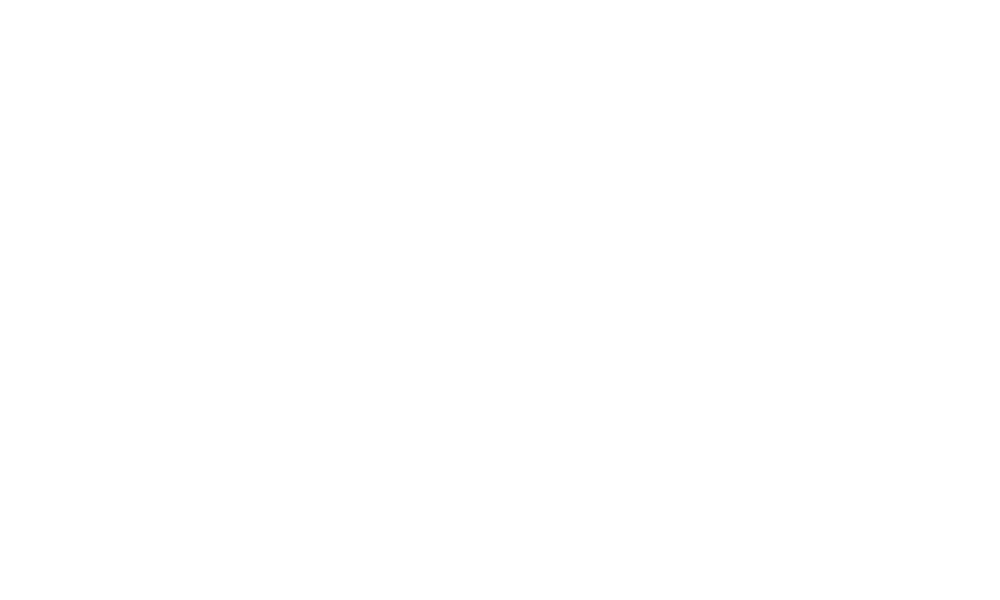

In [208]:
array_results = []

column_names = ["number_of_points", "method", "function", "mse", "X_new", "Y_new"]

functions = ["bohachevsky", "ackley", "himmelblau", "peaks"]

for function in functions:
    if function == "peaks":
        r_min, r_max = -3.0, 3.0
    elif function == "bohachevsky":
        r_min, r_max = -100.0, 100.0
    elif function == "ackley":
        r_min, r_max = -2.0, 2.0
    elif function == "himmelblau":
        r_min, r_max = -5.0, 5.0
    else:
        print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
        break;
                
    xaxis = np.linspace(r_min, r_max, 100)
    yaxis = np.linspace(r_min, r_max, 100)

    x, y = meshgrid(xaxis, yaxis)
    X_new, Y_new = latin_sampler_optimizer(5, r_min, r_max, 'maximin')
    if function == "peaks":
        z = peaks(X_new, Y_new)
    elif function == "bohachevsky":
        z = bohachevsky(X_new, Y_new)
    elif function == "ackley":
        z = ackley(X_new, Y_new)
    elif function == "himmelblau":
        z = himmelblau(X_new, Y_new)
    else:
        print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
        break;

    print("Function: "+function+". r_min, r_max = "+str(r_min)+", "+str(r_max))
                
    for iters in range(0, 45):
        if function == "peaks":
            z = peaks(X_new, Y_new)
        elif function == "bohachevsky":
            z = bohachevsky(X_new, Y_new)
        elif function == "ackley":
            z = ackley(X_new, Y_new)
        elif function == "himmelblau":
            z = himmelblau(X_new, Y_new)
        else:
            print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
            break;

        x_train = np.column_stack((X_new,Y_new))
        y_train = z
        print("Len x_train: "+str(len(x_train))) 
        print("Len y_train: "+str(len(y_train))) 
        
        gaussian_process = gpr_train(x_train, y_train)
        mean_prediction_result, x_coord, y_coord = predict(gaussian_process, x, y, False)
        
        if iters == 0:
            if function == "peaks":
                actual_value = peaks(x_coord, y_coord)
            elif function == "bohachevsky":
                actual_value = bohachevsky(x_coord, y_coord)
            elif function == "ackley":
                actual_value = ackley(x_coord, y_coord)
            elif function == "himmelblau":
                actual_value = himmelblau(x_coord, y_coord)
            else:
                print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
                break;
        errores_mse = mse(x_coord, y_coord, actual_value, mean_prediction_result)
        
        array_results.append([len(X_new), 'distance-based maximin', function, errores_mse, X_new, Y_new])
        
        # NEXT POINT SELECTION:
        
        # K-Folding Variance-based criterium
        cumulative_sum = np.zeros(len(xaxis)*len(yaxis))
        for j in range(0,len(x_train)):
            globals()[f'X_train_{j}'] = np.delete(x_train, j, axis=0)
            globals()[f'Y_train_{j}'] = np.delete(y_train, j, axis=0)
            globals()[f'gaussian_process_{j}'] = gpr_train(globals()[f'X_train_{j}'], globals()[f'Y_train_{j}'])
            globals()[f'mean_prediction_{j}'], globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'] = predict(globals()[f'gaussian_process_{j}'], x, y, False)
            cumulative_sum += globals()[f'mean_prediction_{j}']
            
        mean_prediction_kfolding = cumulative_sum/len(x_train) 
        
        if function == "peaks":
            actual_value = peaks(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        elif function == "bohachevsky":
            actual_value = bohachevsky(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        elif function == "ackley":
            actual_value = ackley(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        elif function == "himmelblau":
            actual_value = himmelblau(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        else:
            print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
            break;
        
        iter_mse = mse(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], actual_value, mean_prediction_kfolding)

        cumulative_variance = np.zeros(len(xaxis)*len(yaxis))
        for j in range(0,len(x_train)):
            cumulative_variance += (globals()[f'mean_prediction_{j}']-mean_prediction_kfolding)**2
        variance = cumulative_variance/len(x_train)

        variances_array = np.column_stack((globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], np.sqrt(variance)))
        max_variance_x, max_variance_y, max_variance = variances_array[variances_array[:,2].argmax(),:]

        print("Max variances: "+str(max_variance))
        print("Max variance x: "+str(max_variance_x))
        print("Max variance y: "+str(max_variance_y))
        print("MSE: "+str(iter_mse))
        
        # Maximum distance criterium
        max_distance_x_list, max_distance_y_list, max_distance_list = maximum_distance_list(x,y,X_new,Y_new)
        
        # Maximum Importance Factor = Relevance Factor
        importance_factor_list =  np.column_stack((max_distance_x_list, max_distance_y_list, np.multiply(max_distance_list, variances_array[:,2])))
        max_importance_x, max_importance_y, max_importance = importance_factor_list[importance_factor_list[:,2].argmax(),:]
        
        print("Point: ", max_importance_x, max_importance_y, "MSE :", errores_mse)
        
        X_new = np.append(X_new, max_importance_x)
        Y_new = np.append(Y_new, max_importance_y)
        
        
        iters+=1
        
df_distance_based_maximin = pd.DataFrame(array_results, columns = column_names)
df_distance_based_maximin.to_csv('mixed_sampling_maximin_run_5.csv')

x_prueba, y_prueba, distance_prueba = maximum_distance_list(x,y,X_new,Y_new)


surf_plot_3d(distances_df.point.str[0], distances_df.point.str[1], np.multiply(distance_prueba, variances_array[:,2]))

# Mixed adaptive Active Learning (Vertex-based Starting Criteria)

The Relevance Factor (RF) is obtained for each position in space as a combination of the maximum uncertainty ($\eta_{x,y}$, variance-based) and the maximum Euclidean distance to the closest point ($d^{\mathbb{R2}}_{x,y}$, space-filling).

$$
RF = \eta_{x,y}\cdot d^{\mathbb{R2}}_{x,y}
$$


In [326]:
array_results = []

column_names = ["number_of_points", "method", "function", "mse", "X_new", "Y_new"]

functions = ["bohachevsky", "ackley", "himmelblau", "peaks"]

for function in functions:
    if function == "peaks":
        r_min, r_max = -3.0, 3.0
    elif function == "bohachevsky":
        r_min, r_max = -100.0, 100.0
    elif function == "ackley":
        r_min, r_max = -2.0, 2.0
    elif function == "himmelblau":
        r_min, r_max = -5.0, 5.0
    else:
        print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
        break;
                
    xaxis = np.linspace(r_min, r_max, 100)
    yaxis = np.linspace(r_min, r_max, 100)

    x, y = meshgrid(xaxis, yaxis)
    X_new, Y_new = vertex_sampler(2, r_min, r_max)
    if function == "peaks":
        z = peaks(X_new, Y_new)
    elif function == "bohachevsky":
        z = bohachevsky(X_new, Y_new)
    elif function == "ackley":
        z = ackley(X_new, Y_new)
    elif function == "himmelblau":
        z = himmelblau(X_new, Y_new)
    else:
        print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
        break;

    print("Function: "+function+". r_min, r_max = "+str(r_min)+", "+str(r_max))
                
    for iters in range(0, 45):
        if function == "peaks":
            z = peaks(X_new, Y_new)
        elif function == "bohachevsky":
            z = bohachevsky(X_new, Y_new)
        elif function == "ackley":
            z = ackley(X_new, Y_new)
        elif function == "himmelblau":
            z = himmelblau(X_new, Y_new)
        else:
            print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
            break;

        x_train = np.column_stack((X_new,Y_new))
        y_train = z
        print("Len x_train: "+str(len(x_train))) 
        print("Len y_train: "+str(len(y_train))) 
        
        gaussian_process = gpr_train(x_train, y_train)
        mean_prediction_result, x_coord, y_coord = predict(gaussian_process, x, y, False)
        
        if iters == 0:
            if function == "peaks":
                actual_value = peaks(x_coord, y_coord)
            elif function == "bohachevsky":
                actual_value = bohachevsky(x_coord, y_coord)
            elif function == "ackley":
                actual_value = ackley(x_coord, y_coord)
            elif function == "himmelblau":
                actual_value = himmelblau(x_coord, y_coord)
            else:
                print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
                break;
        errores_mse = mse(x_coord, y_coord, actual_value, mean_prediction_result)
        
        array_results.append([len(X_new), 'distance-based maximin', function, errores_mse, X_new, Y_new])
        
        # NEXT POINT SELECTION:
        
        # K-Folding Variance-based criterium
        cumulative_sum = np.zeros(len(xaxis)*len(yaxis))
        for j in range(0,len(x_train)):
            globals()[f'X_train_{j}'] = np.delete(x_train, j, axis=0)
            globals()[f'Y_train_{j}'] = np.delete(y_train, j, axis=0)
            globals()[f'gaussian_process_{j}'] = gpr_train(globals()[f'X_train_{j}'], globals()[f'Y_train_{j}'])
            globals()[f'mean_prediction_{j}'], globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'] = predict(globals()[f'gaussian_process_{j}'], x, y, False)
            cumulative_sum += globals()[f'mean_prediction_{j}']
            
        mean_prediction_kfolding = cumulative_sum/len(x_train) 
        
        if function == "peaks":
            actual_value = peaks(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        elif function == "bohachevsky":
            actual_value = bohachevsky(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        elif function == "ackley":
            actual_value = ackley(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        elif function == "himmelblau":
            actual_value = himmelblau(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'])
        else:
            print("No correct function specified. Available: peaks, bohachevsky, ackley, himmelblau")
            break;
        
        iter_mse = mse(globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], actual_value, mean_prediction_kfolding)

        cumulative_variance = np.zeros(len(xaxis)*len(yaxis))
        for j in range(0,len(x_train)):
            cumulative_variance += (globals()[f'mean_prediction_{j}']-mean_prediction_kfolding)**2
        variance = cumulative_variance/len(x_train)

        variances_array = np.column_stack((globals()[f'x_coord_{j}'], globals()[f'y_coord_{j}'], np.sqrt(variance)))
        max_variance_x, max_variance_y, max_variance = variances_array[variances_array[:,2].argmax(),:]

        print("Max variances: "+str(max_variance))
        print("Max variance x: "+str(max_variance_x))
        print("Max variance y: "+str(max_variance_y))
        print("MSE: "+str(iter_mse))
        
        # Maximum distance criterium
        max_distance_x_list, max_distance_y_list, max_distance_list = maximum_distance_list(x,y,X_new,Y_new)
        
        # Maximum Importance Factor = Relevance Factor
        importance_factor_list =  np.column_stack((max_distance_x_list, max_distance_y_list, np.multiply(max_distance_list, variances_array[:,2])))
        max_importance_x, max_importance_y, max_importance = importance_factor_list[importance_factor_list[:,2].argmax(),:]
        
        print("Point: ", max_importance_x, max_importance_y, "MSE :", errores_mse)
        
        X_new = np.append(X_new, max_importance_x)
        Y_new = np.append(Y_new, max_importance_y)
        
        
        iters+=1
        
df_distance_based_maximin = pd.DataFrame(array_results, columns = column_names)
df_distance_based_maximin.to_csv('mixed_sampling_vertex_run_1.csv')

x_prueba, y_prueba, distance_prueba = maximum_distance_list(x,y,X_new,Y_new)


surf_plot_3d(distances_df.point.str[0], distances_df.point.str[1], np.multiply(distance_prueba, variances_array[:,2]))

Function: bohachevsky. r_min, r_max = -100.0, 100.0
Len x_train: 5
Len y_train: 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_pr

KeyboardInterrupt: 